In [1]:
import deimos
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold
import random as rd
import matplotlib
matplotlib.rcParams['figure.dpi'] = 100
import sys
import PeakDetective
import PeakDetective.detection_helper as detection_helper
import scipy.stats as stats
import seaborn as sb
from matplotlib.colors import LinearSegmentedColormap
from sklearn.metrics import confusion_matrix
import sklearn.metrics as met
import random as rd
import importlib
import pickle as pkl
import NeatMS as ntms
from copy import deepcopy

def makePRCPlot(pred,true,noSkill=True,label=""):

    prec, recall, threshs = met.precision_recall_curve(true, pred)

    auc = np.round(met.auc(recall, prec), 4)

    plt.plot(recall, prec, label=label + " prAUC=" + str(auc))
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    if noSkill:
        numPositive = len([x for x in true if x > 0.5])
        numNegative = len(true) - numPositive
        plt.plot([0, 1.0],
                 [numPositive / float(numPositive + numNegative), numPositive / float(numPositive + numNegative)],
                 label="NSL prAUC=" + str(
                     np.round(numPositive / float(numPositive + numNegative), 4)))
    plt.legend()
    return auc

def makeViolinPlot(pred,true):
    
    plt_dict = {}
    
    for p,t in zip(pred,true):
        if t > 0.5:
            group = "true peak"
        else:
            group = "artifact"
        plt_dict[len(plt_dict)] = {"group":group,"prediction":p}
        
    plt_dict = pd.DataFrame.from_dict(plt_dict,orient="index")
    
    sb.violinplot(data=plt_dict,x="group",y="prediction",cut=0)
    
def makeROCPlot(pred,true,label="",noSkill=True,color=None):

    fpr, tpr, threshs = met.roc_curve(true, pred)

    auc = np.round(met.auc(fpr, tpr), 4)

    if color is None: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc))
    else: plt.plot(fpr, tpr, label=label + ": AUROC=" + str(auc),color=color)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    if noSkill:
        plt.plot([0, 1.0],[0,1.0],label="NSL",color="grey",linestyle="--")
    plt.legend()
    return auc

def plot_overlayedEIC(rawdatas,mz,rt_start,rt_end,resolution=60,smoothing=0,alpha=0.3,color="black"):
    ts = np.linspace(rt_start,rt_end,resolution)
    for data in rawdatas:
        s = data.interpolate_data(mz,rt_start,rt_end)
        ints  = [np.max([x,0]) for x in s(ts)]
        plt.plot(ts,ints,alpha=alpha)

In [2]:
#importlib.reload(PeakDetective)

In [3]:
resolution = 60
window = 1.0

align = True

In [4]:
#covid_plasma
datadir = "D:/PeakDetective/data/covid_plasma/"
ms1ppm = 25.5
peakWidth = (13.8,114.6)
s2n = 13.6
noise = 1
mzDiff = 0.0144
prefilter = 5
cutoff = 0.75 #default cutoff from last run

In [13]:
#ST000081
datadir = "D:/PeakDetective/data/ST000081/"
ms1ppm = 11.5
peakWidth = (8.5,31.3)
s2n = 6.81
noise = 1
mzDiff = 0.0144
prefilter = 5.4
cutoff = 0.6 #default cutoff from last run

In [20]:
#ST001882_GT_RP_Positive
datadir = "D:/PeakDetective/data/ST001882_GT_RP_Positive/"
ms1ppm = 11.5
peakWidth = (8.576,30)
s2n = 9.1
noise = 12970
mzDiff = 0.0144
prefilter = 1
cutoff = 0.5 #default cutoff from last run

In [1]:
#yeast 
datadir = "D:/PeakDetective/data/yeast_spike_in/"
ms1ppm = 5
peakWidth = (18,65)
s2n = 10
noise = 100
mzDiff = 0.01
prefilter = 1
cutoff = 0.5 #default cutoff from last run

In [31]:
#ST000992
datadir = "D:/PeakDetective/data/ST000992/"
ms1ppm = 45
peakWidth = (5,20)
s2n = 1.46
noise = 1
mzDiff = 0.0012
prefilter = 5.4
cutoff = 0.5 #default cutoff from last run

In [32]:
rawDataDir = datadir + "tmp/"

In [33]:
det = detection_helper.PeakList()
#det.runXCMS(datadir, "xcms_peak_list.csv", "negative", ms1ppm, peakWidth,s2n=s2n,noise=noise,mzDiff=mzDiff,prefilter=prefilter)
det.readXCMSPeakList(datadir+"xcms_peak_list.csv")
#det.to_skyline(datadir+"xcms_peak_list_transition_list.csv","Negative",moleculeListName = "XCMS peaks")
peakList = pd.DataFrame(det.peakList)
#peakList = peakList[["mz","rt"]]
peakList

mz         rt   rt_start     rt_end  \
FT00001   55.054837   0.909417   0.901114   1.000666   
FT00002   55.002434   3.730101   3.730100   3.738400   
FT00003   55.018809   1.933970   1.896627   1.962994   
FT00004   55.054653   0.743483   0.743483   0.743483   
FT00005   55.054752   4.476767   4.476766   4.476767   
...             ...        ...        ...        ...   
FT50838  999.498535  24.910350  24.910350  24.910350   
FT50839  999.430941  19.841367  19.841367  19.841367   
FT50840  999.512648  23.624417  23.624417  23.624417   
FT50841  999.513860  25.316866  25.316866  25.316866   
FT50842  999.519426  25.441300  25.441300  25.441300   

         20150811-EX00468-A003-IN0016-PO-CS0000009.1-P.mzML  \
FT00001                                       34692.470386    
FT00002                                        2357.065214    
FT00003                                         533.653993    
FT00004                                       14567.430064    
FT00005                                        1558.607357    
...                                                    ...    
FT50838                                        1644.995349    
FT50839                                          83.674609    
FT50840                                          58.621953    
FT50841                                        5278.523244    
FT50842                                         360.989334    

         20150811-EX00468-A003-IN0016-PO-CS0000009.2-P.mzML  \
FT00001                                       37445.955582    
FT00002                                        2046.382657    
FT00003                                        7203.163504    
FT00004                                       12742.963550    
FT00005                                        1328.057506    
...                                                    ...    
FT50838                                        3396.741659    
FT50839                                        1188.739090    
FT50840                                        2588.143328    
FT50841                                        5318.153099    
FT50842                                        1761.552729    

         20150811-EX00468-A003-IN0016-PO-CS0000009.3-P.mzML  
FT00001                                       52001.188664   
FT00002                                        2782.086266   
FT00003                                       10286.867705   
FT00004                                       13199.919427   
FT00005                                        1783.424362   
...                                                    ...   
FT50838                                        1508.138291   
FT50839                                         487.026611   
FT50840                                           0.000000   
FT50841                                        6574.284243   
FT50842                                         706.587443   

[50842 rows x 7 columns]

In [23]:
neatMSPeakList = pd.read_csv(datadir + "xcms_peak_list.csv",sep="\t",index_col=0)
neatMSPeakList["feature_id"] = neatMSPeakList.index.values
neatMSPeakList["feature_id2"] = neatMSPeakList.index.values
neatMSPeakList = neatMSPeakList.melt(id_vars = ["mzmed","rtmed","rtmin","rtmax","feature_id"],
                    value_vars = [x for x in neatMSPeakList.columns.values if ".mzML" in x],
                   var_name="sample", value_name="into")
neatMSPeakList["mzmin"] = neatMSPeakList["mzmed"].values - (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["mzmax"] = neatMSPeakList["mzmed"].values + (ms1ppm * neatMSPeakList["mzmed"].values) / 1e6
neatMSPeakList["intb"] = neatMSPeakList["into"].values
neatMSPeakList["maxo"] = neatMSPeakList["into"].values
neatMSPeakList["sn"] = [10 for _ in range(len(neatMSPeakList))]
neatMSPeakList["sample_name"] = neatMSPeakList["sample"].values
neatMSPeakList["rtmin"] = neatMSPeakList["rtmin"].values - .2 * 60
neatMSPeakList["rtmax"] = neatMSPeakList["rtmin"].values + .2 * 60
neatMSPeakList = neatMSPeakList.rename({"mzmed":"mz","rtmed":"rt"},axis=1)

neatMSPeakList.to_csv(datadir + "neatms_peak_list.csv",index=False)
neatMSPeakList


mz          rt       rtmin       rtmax feature_id  \
0        150.112310   44.847397   32.847004   44.847004    FT00001   
1        150.026482  104.976143   92.861908  104.861908    FT00002   
2        150.026490  170.748657  158.745468  170.745468    FT00003   
3        150.062904   75.329934   63.305313   75.305313    FT00004   
4        150.091273   50.744864   37.897064   49.897064    FT00005   
...             ...         ...         ...         ...        ...   
225262  1974.536430  528.918945  516.918945  528.918945    FT32177   
225263  1979.207415  374.987793  362.395142  374.395142    FT32178   
225264  1980.210251  374.978076  362.411835  374.411835    FT32179   
225265  1981.211674  374.972961  362.423401  374.423401    FT32180   
225266  1982.212953  374.974823  362.407043  374.407043    FT32181   

            sample          into        mzmin        mzmax          intb  \
0       QC_01.mzML  1.974936e+06   150.110584   150.114036  1.974936e+06   
1       QC_01.mzML  2.826669e+07   150.024757   150.028207  2.826669e+07   
2       QC_01.mzML  8.213799e+06   150.024765   150.028215  8.213799e+06   
3       QC_01.mzML  3.205281e+05   150.061178   150.064630  3.205281e+05   
4       QC_01.mzML  2.072345e+05   150.089547   150.092999  2.072345e+05   
...            ...           ...          ...          ...           ...   
225262  QC_07.mzML  2.039624e+05  1974.513723  1974.559137  2.039624e+05   
225263  QC_07.mzML  7.916662e+04  1979.184654  1979.230176  7.916662e+04   
225264  QC_07.mzML  2.108537e+05  1980.187479  1980.233024  2.108537e+05   
225265  QC_07.mzML  2.104139e+05  1981.188890  1981.234458  2.104139e+05   
225266  QC_07.mzML  1.249721e+05  1982.190158  1982.235748  1.249721e+05   

                maxo  sn sample_name  
0       1.974936e+06  10  QC_01.mzML  
1       2.826669e+07  10  QC_01.mzML  
2       8.213799e+06  10  QC_01.mzML  
3       3.205281e+05  10  QC_01.mzML  
4       2.072345e+05  10  QC_01.mzML  
...              ...  ..         ...  
225262  2.039624e+05  10  QC_07.mzML  
225263  7.916662e+04  10  QC_07.mzML  
225264  2.108537e+05  10  QC_07.mzML  
225265  2.104139e+05  10  QC_07.mzML  
225266  1.249721e+05  10  QC_07.mzML  

[225267 rows x 13 columns]

In [24]:
feature_table_path = datadir+"neatms_peak_list.csv"
input_data = 'xcms'
experiment = ntms.Experiment(rawDataDir, feature_table_path, input_data)

In [25]:
nn_handler = ntms.NN_handler(experiment,min_scan_num=0)

In [9]:
model_path = "../data/neatms/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

In [10]:
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

1583/1583 [==============================] - 12s 8ms/step


In [11]:
# We create the dataframe using this function
NeatMS_output_df = experiment.export_to_dataframe()
# And display it
NeatMS_output_df

feature ID                                         sample         m/z  \
0                0  20150811-EX00468-A003-IN0016-PO-CS0000009.1-P   55.054837   
1                0  20150811-EX00468-A003-IN0016-PO-CS0000009.2-P   55.054837   
2                0  20150811-EX00468-A003-IN0016-PO-CS0000009.3-P   55.054837   
3                1  20150811-EX00468-A003-IN0016-PO-CS0000009.1-P   55.002434   
4                1  20150811-EX00468-A003-IN0016-PO-CS0000009.2-P   55.002434   
...            ...                                            ...         ...   
151820       50840  20150811-EX00468-A003-IN0016-PO-CS0000009.2-P  999.513860   
151821       50840  20150811-EX00468-A003-IN0016-PO-CS0000009.3-P  999.513860   
151822       50841  20150811-EX00468-A003-IN0016-PO-CS0000009.1-P  999.519426   
151823       50841  20150811-EX00468-A003-IN0016-PO-CS0000009.2-P  999.519426   
151824       50841  20150811-EX00468-A003-IN0016-PO-CS0000009.3-P  999.519426   

        retention time        height          area  label  
0             0.909417  34692.470386  34692.470386  Noise  
1             0.909417  37445.955582  37445.955582  Noise  
2             0.909417  52001.188664  52001.188664  Noise  
3             3.730101   2357.065214   2357.065214  Noise  
4             3.730101   2046.382657   2046.382657  Noise  
...                ...           ...           ...    ...  
151820       25.316866   5318.153099   5318.153099  Noise  
151821       25.316866   6574.284243   6574.284243  Noise  
151822       25.441300    360.989334    360.989334  Noise  
151823       25.441300   1761.552729   1761.552729  Noise  
151824       25.441300    706.587443    706.587443  Noise  

[151825 rows x 7 columns]

In [12]:
NeatMS_output_df.to_csv(datadir + "NeatMS_output_df.csv")

In [118]:
NeatMS_output_df= pd.read_csv(datadir + "NeatMS_output_df.csv",index_col=0)
NeatMS_output_df

feature ID              sample          m/z  retention time  \
0               1  B1_NIST1950_1_6540    54.977012        5.074017   
1               1  B1_NIST1950_2_6540    54.977012        5.074017   
2               1  B1_NIST1950_3_6540    54.977012        5.074017   
3               2  B1_NIST1950_1_6540    55.018832        6.038233   
4               2  B1_NIST1950_2_6540    55.018832        6.038233   
...           ...                 ...          ...             ...   
12092        4186  B1_NIST1950_2_6540  1613.977307       14.982067   
12093        4186  B1_NIST1950_3_6540  1613.977307       14.982067   
12094        4187  B1_NIST1950_1_6540  1613.978958       12.721182   
12095        4187  B1_NIST1950_2_6540  1613.978958       12.721182   
12096        4187  B1_NIST1950_3_6540  1613.978958       12.721182   

              height           area         label  
0      153221.001212  153221.001212         Noise  
1      121049.319269  121049.319269         Noise  
2      121518.648674  121518.648674         Noise  
3        6447.719840    6447.719840         Noise  
4        9208.601970    9208.601970         Noise  
...              ...            ...           ...  
12092   49999.415489   49999.415489  High_quality  
12093   23885.945518   23885.945518         Noise  
12094   13252.754702   13252.754702         Noise  
12095   15256.555134   15256.555134         Noise  
12096   22642.497262   22642.497262  High_quality  

[12097 rows x 7 columns]

In [34]:
files = [x for x in os.listdir(datadir) if ".mzML" in x]
print(files)
raw_data = []
for file in files:
    temp = PeakDetective.rawData()
    temp.readRawDataFile(datadir + file,ms1ppm)
    raw_data.append(temp)
    

['20150811-EX00468-A003-IN0016-PO-CS0000009.1-P.mzML', '20150811-EX00468-A003-IN0016-PO-CS0000009.2-P.mzML', '20150811-EX00468-A003-IN0016-PO-CS0000009.3-P.mzML']


In [35]:
raw_data[0].rts[:10]

[0.035516666667 minute,
 0.043816666667 minute,
 0.052116666667 minute,
 0.0604 minute,
 0.0687 minute,
 0.077 minute,
 0.0853 minute,
 0.093583333333 minute,
 0.101883333333 minute,
 0.110183333333 minute]

In [36]:
integ = PeakDetective.PeakDetective(numCores = 15,resolution=resolution)

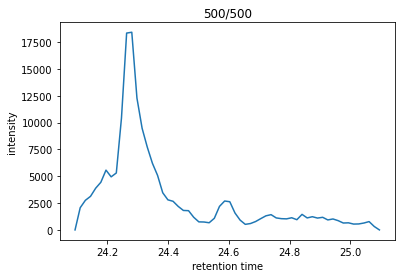

Enter classification (1=True Peak, 0=Artifact): 


 1


In [11]:
if __name__ == "__main__":
    inds = list(peakList.index.values)
    inds = rd.sample(inds,500)
    tmp = peakList.loc[inds,:]
    print(tmp)
    peakList_labeled = integ.label_peaks(raw_data[0],tmp)
    peakList_labeled.to_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"))

In [37]:
peakList_labeled = pd.read_csv(datadir + files[0].replace(".mzML","_classified_peaks.csv"),index_col=0)

In [38]:
peakList_labeled

mz         rt   rt_start     rt_end  \
FT46981  923.418679   2.477361   2.477361   2.477361   
FT24655  493.334642  21.376152  21.376152  21.376152   
FT26782  535.683113  22.877747  22.877747  22.877747   
FT44744  881.484663  22.214067  22.214067  22.214067   
FT46822  920.396724  19.816474  19.808183  19.824766   
...             ...        ...        ...        ...   
FT25338  506.269314  20.654382  20.646080  20.654383   
FT23791  477.355097  22.761617  22.761615  22.761839   
FT00879   95.973712   3.904316   3.829652   3.929217   
FT49823  978.124322   0.561752   0.545938   0.577567   
FT44093  870.529047  24.595100  24.587292  24.595101   

         20150811-EX00468-A003-IN0016-PO-CS0000009.1-P.mzML  \
FT46981                                        1607.529719    
FT24655                                         709.807176    
FT26782                                         779.051366    
FT44744                                         659.206639    
FT46822                                         584.094484    
...                                                    ...    
FT25338                                        2165.511667    
FT23791                                       14430.708985    
FT00879                                       15665.887196    
FT49823                                         897.005452    
FT44093                                       13712.295574    

         20150811-EX00468-A003-IN0016-PO-CS0000009.2-P.mzML  \
FT46981                                         619.799469    
FT24655                                         242.669216    
FT26782                                         109.692875    
FT44744                                        1051.785972    
FT46822                                         604.763634    
...                                                    ...    
FT25338                                        2365.414442    
FT23791                                       14156.271756    
FT00879                                       25331.435938    
FT49823                                           0.000000    
FT44093                                       14007.695817    

         20150811-EX00468-A003-IN0016-PO-CS0000009.3-P.mzML  classification  
FT46981                                         798.851511              0.0  
FT24655                                           0.000000              0.0  
FT26782                                         326.987186              0.0  
FT44744                                        1468.050848              0.0  
FT46822                                        1021.219808              0.0  
...                                                    ...              ...  
FT25338                                        2514.705765              0.0  
FT23791                                       19869.007074              1.0  
FT00879                                       23538.019472              0.0  
FT49823                                         496.327041              0.0  
FT44093                                       14931.595494              1.0  

[500 rows x 8 columns]

In [39]:
try: os.mkdir(datadir + "manually_labeled_peaks/")
except: pass
for index,row in peakList_labeled.iterrows():
    plot_overlayedEIC(raw_data[:1],row["mz"],row["rt"]-.5,row["rt"] + .5,resolution=resolution,alpha=1.0)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    if row["classification"] > 0.5:
        plt.title("label="+"True Peak")
    else:
        plt.title("label="+"Artifact")
    plt.savefig(datadir + "manually_labeled_peaks/" + index + ".png",dpi=300)
    plt.close()

In [13]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X_unaligned = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=False)

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [14]:
if __name__ == "__main__":
    rts = peakList["rt"].values
    X = integ.makeDataMatrix(raw_data,peakList["mz"],rts,align=align)
    

forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 


Text(0, 0.5, 'intensity')

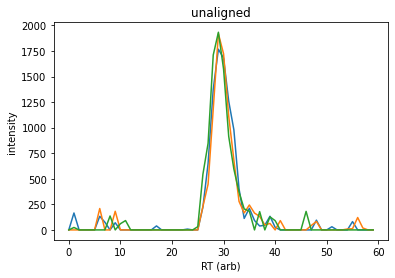

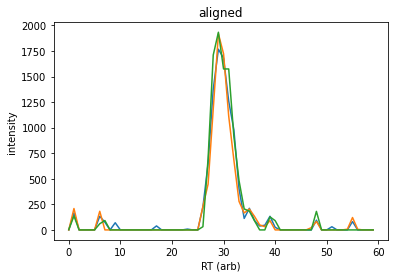

In [15]:
ind = rd.choice(list(range(len(peakList.index.values))))
aligned = []
unaligned = []
for x in range(len(raw_data)):
    aligned.append(X[x*len(peakList) + ind])
    unaligned.append(X_unaligned[x*len(peakList) + ind])
plt.figure()
plt.title("unaligned")
for x in unaligned:
    plt.plot(range(len(x)),x)
plt.xlabel("RT (arb)")
plt.ylabel("intensity")

plt.figure()
plt.title("aligned")
for x in aligned:
    plt.plot(range(len(x)),x)
plt.xlabel("RT (arb)")
plt.ylabel("intensity")
    

In [16]:
if __name__ == "__main__":
    rts = peakList_labeled["rt"].values
    X_labeled = integ.makeDataMatrix(raw_data[:1],peakList_labeled["mz"],peakList_labeled["rt"],align=False)
    y_labeled = peakList_labeled["classification"].values
    y_labeled = np.array([[-1*y + 1,y] for y in y_labeled])

forming matrix |██████████████████████████████████████████████████| 100.0% 


In [17]:
raw_data[0].rts[:10]

[0.035516666667 minute,
 0.043816666667 minute,
 0.052116666667 minute,
 0.0604 minute,
 0.0687 minute,
 0.077 minute,
 0.0853 minute,
 0.093583333333 minute,
 0.101883333333 minute,
 0.110183333333 minute]

In [19]:
#if __name__ == "__main__":
    #oldCores = integ.numCores
    #integ.numCores = 1
    #X_signal = integ.generateSignalPeaks(peakList,raw_data[:1],n=100)
    #X_noise = integ.generateFalsePeaks(peakList,raw_data[:1],n=100)
    #X_syn = np.concatenate((X_signal,X_noise),axis=0)
    #y_syn = np.array([[0.0,1.0] for _ in X_signal] + [[1.0,0.0] for _ in X_noise])
    #integ.numCores = oldCores

In [20]:
pkl.dump([X,X_labeled,y_labeled,[],[]],open(datadir + "model_selection_data.pkl","wb"))

In [123]:
[X,X_labeled,y_labeled,X_syn,y_syn] = pkl.load(open(datadir + "model_selection_data.pkl","rb"))

In [22]:
if __name__ == "__main__":
    integ.trainSmoother(peakList,raw_data,100000,10,64,0.1)

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
done
fitting smoother...
Epoch 1/10
1407/1407 [==============================] - 33s 23ms/step - loss: 0.1277 - mean_absolute_error: 0.0578 - val_loss: 0.0829 - val_mean_absolute_error: 0.0220
Epoch 2/10
1407/1407 [==============================] - 32s 23ms/step - loss: 0.0786 - mean_absolute_error: 0.0206 - val_loss: 0.0767 - val_mean_absolute_error: 0.0192
Epoch 3/10
1407/1407 [==============================] - 32s 23ms/step - loss: 0.0751 - mean_absolute_error: 0.0188 - val_loss: 0.0754 - val_mean_absolute_error: 0.0185
Epoch 4/10
1407/1407 [==============================] - 33s 23ms/step - loss: 0.0740 - mean_absolute_error: 0.0182 - val_loss: 0.0748 - val_mean_absolute_error: 0.0183
Epoch 5/10
1407/1407 [==============================] - 33s 23ms/step - loss: 0.0734 - mean_absolute_error: 0.0178 - val_loss: 0.0744 - val_mean_absolute_error: 0.0180
Epoch 6/10
1407/1407 [==================

In [23]:
integ.save(datadir + "smoothed_only/")

In [124]:
integ.load(datadir + "smoothed_only/")

In [25]:
valInds = list(range(len(X_labeled)))
valInds = rd.sample(valInds,k=250)
testInds = rd.sample(valInds,k=200)
valInds = [x for x in valInds if x not in testInds]

X_val = X_labeled[valInds]
y_val = y_labeled[valInds]

X_test = X_labeled[testInds]
y_test = y_labeled[testInds]

X_labeled = X_labeled[[x for x in range(len(X_labeled)) if x not in valInds + testInds]]
y_labeled = y_labeled[[x for x in range(len(y_labeled)) if x not in valInds + testInds]]

In [26]:
peaks_test = peakList_labeled.iloc[testInds,:].reset_index()
peaks_test

index          mz         rt   rt_start     rt_end  \
0    FT40784  816.589785  25.474483  25.466199  25.474483   
1    FT26957  539.192559  10.761132  10.756983  10.765280   
2    FT04007  162.052128   8.533588   8.525317   8.533609   
3    FT34963  706.795830  28.900800  28.900800  28.900800   
4    FT25338  506.269314  20.654382  20.646080  20.654383   
..       ...         ...        ...        ...        ...   
195  FT10063  257.091238  28.187335  28.187335  28.187335   
196  FT46876  921.650252  26.158917  26.154767  26.163067   
197  FT21227  429.263761  20.919867  20.919867  20.919867   
198  FT40073  806.161177  24.454067  24.420884  24.488662   
199  FT31757  638.322259  10.391957  10.391950  10.400252   

     20150811-EX00468-A003-IN0016-PO-CS0000009.1-P.mzML  \
0                                         32750.677356    
1                                           508.175529    
2                                         19216.979264    
3                                          2804.932939    
4                                          2165.511667    
..                                                 ...    
195                                         483.014160    
196                                        1658.865865    
197                                         915.790312    
198                                        1854.975740    
199                                        1026.987288    

     20150811-EX00468-A003-IN0016-PO-CS0000009.2-P.mzML  \
0                                         34104.280392    
1                                           751.740824    
2                                         18847.326979    
3                                          2758.355409    
4                                          2365.414442    
..                                                 ...    
195                                         198.488892    
196                                        1013.179460    
197                                         218.705801    
198                                        2244.433441    
199                                         809.350679    

     20150811-EX00468-A003-IN0016-PO-CS0000009.3-P.mzML  classification  
0                                         40028.503614              0.0  
1                                           305.173654              1.0  
2                                         16289.568984              1.0  
3                                          2842.547898              0.0  
4                                          2514.705765              0.0  
..                                                 ...              ...  
195                                         139.272954              0.0  
196                                         543.703271              0.0  
197                                         803.221308              0.0  
198                                        2640.497070              0.0  
199                                         937.661864              1.0  

[200 rows x 9 columns]

In [27]:
pkl.dump([peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled],open(datadir+"eval_data.pkl","wb"))

In [125]:
[peaks_test,X_val,y_val,X_test,y_test,X_labeled,y_labeled] = pkl.load(open(datadir+"eval_data.pkl","rb"))

In [126]:
filt = NeatMS_output_df[NeatMS_output_df["sample"] == files[0].replace(".mzML","")]
filt

feature ID              sample          m/z  retention time  \
0               1  B1_NIST1950_1_6540    54.977012        5.074017   
3               2  B1_NIST1950_1_6540    55.018832        6.038233   
6               3  B1_NIST1950_1_6540    56.995900       13.086900   
9               4  B1_NIST1950_1_6540    57.034581        1.590991   
12              5  B1_NIST1950_1_6540    57.028878       12.804283   
...           ...                 ...          ...             ...   
12082        4183  B1_NIST1950_1_6540  1612.974722        2.214650   
12085        4184  B1_NIST1950_1_6540  1612.976154       14.982067   
12088        4185  B1_NIST1950_1_6540  1613.978101        2.214650   
12091        4186  B1_NIST1950_1_6540  1613.977307       14.982067   
12094        4187  B1_NIST1950_1_6540  1613.978958       12.721182   

             height          area         label  
0      1.532210e+05  1.532210e+05         Noise  
3      6.447720e+03  6.447720e+03         Noise  
6      6.127502e+06  6.127502e+06         Noise  
9      3.627522e+04  3.627522e+04         Noise  
12     2.734232e+03  2.734232e+03  High_quality  
...             ...           ...           ...  
12082  1.910637e+04  1.910637e+04         Noise  
12085  1.358256e+04  1.358256e+04         Noise  
12088  3.174946e+03  3.174946e+03         Noise  
12091  2.855932e+04  2.855932e+04         Noise  
12094  1.325275e+04  1.325275e+04         Noise  

[4034 rows x 7 columns]

In [127]:
matchIDs = {}
for index,row in peaks_test.iterrows():
    for index2,row2 in filt.iterrows():
        if row2["m/z"] > row["mz"] + 0.001:
            break
        if np.abs(row["rt"] - row2["retention time"]) < 0.03:
            if np.abs(row["mz"] - row2["m/z"]) < 0.001:
                matchIDs[index] = index2
                break
print(len(matchIDs))        

147


In [128]:
order = list(matchIDs.keys())
filt = filt.loc[[matchIDs[x] for x in order],:]
classification = []
for index,row in filt.iterrows():
    if row["label"] == "High_quality":
        classification.append(1.0)
    elif row["label"] == "Low_quality":
        classification.append(0.5)
    else:
        classification.append(0.0)
filt["classification"] = classification
filt

feature ID              sample         m/z  retention time  \
10717        3719  B1_NIST1950_1_6540  638.103711        0.724168   
4403         1525  B1_NIST1950_1_6540  254.624195        0.834850   
10846        3765  B1_NIST1950_1_6540  666.784066       13.086900   
5069         1750  B1_NIST1950_1_6540  275.202386        0.851467   
8450         2924  B1_NIST1950_1_6540  442.265574        0.984468   
...           ...                 ...         ...             ...   
4241         1471  B1_NIST1950_1_6540  249.975378        9.047198   
9940         3448  B1_NIST1950_1_6540  550.455573        0.784983   
10735        3725  B1_NIST1950_1_6540  640.129377        0.917967   
6710         2320  B1_NIST1950_1_6540  340.236364        0.934592   
5259         1815  B1_NIST1950_1_6540  283.064220        6.154736   

              height           area         label  classification  
10717    6050.758047    6050.758047  High_quality             1.0  
4403    98824.035679   98824.035679         Noise             0.0  
10846    8112.694799    8112.694799         Noise             0.0  
5069    46051.935219   46051.935219         Noise             0.0  
8450     6923.086015    6923.086015         Noise             0.0  
...              ...            ...           ...             ...  
4241   323861.620950  323861.620950         Noise             0.0  
9940    22174.686775   22174.686775         Noise             0.0  
10735    8536.802503    8536.802503  High_quality             1.0  
6710    79630.589056   79630.589056         Noise             0.0  
5259     2902.056490    2902.056490         Noise             0.0  

[147 rows x 8 columns]

In [129]:
X_labeled_norm = PeakDetective.normalizeMatrix(X_labeled)
X_labeled_smoothed = integ.smoother.predict(PeakDetective.normalizeMatrix(X_labeled))

8/8 [==============================] - 0s 15ms/step


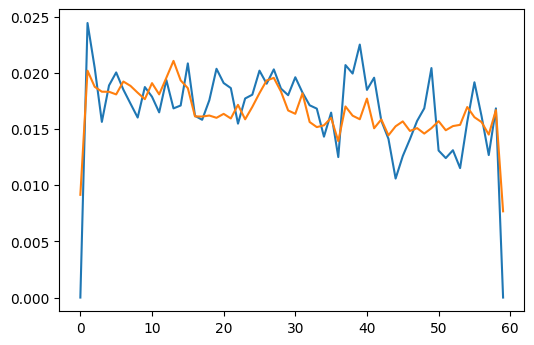

In [130]:
ind = rd.choice(list(range(len(X_labeled))))
plt.plot(X_labeled_norm[ind])
plt.plot(X_labeled_smoothed[ind])

In [131]:
X_test = X_test[order]
y_test = y_test[order]

In [132]:
y_test_scores_neat_ms = filt["classification"].values

In [36]:
if __name__ == "__main__":
    integ.trainClassifier(X_labeled,y_labeled,X_val,y_val,200,1000,4,1)

2/2 [==============================] - 0s 1ms/step
loss: 0.34725016355514526 mean_absolute_error: 0.1716407835483551 val loss: 0.26798662543296814 val_mean_absolute_error: 0.12035073339939117 numEpochs: 421


In [37]:
integ.save(datadir + "supervised/")

In [133]:
integ.load(datadir + "supervised/")

In [134]:
y_test_scores_supervised = integ.classifyMatrix(X_test)

5/5 [==============================] - 0s 4ms/step


In [40]:
# if __name__ == "__main__":
#      integ.trainClassifier(X_syn,y_syn,X_val,y_val,200,1000,32,5)

In [41]:
# y_test_scores_syn = integ.classifyMatrix(X_test)

1/1 [==============================] - 0s 32ms/step
loss: 0.28140920400619507 mean_absolute_error: 0.12868177890777588 val loss: 0.18861253559589386 val_mean_absolute_error: 0.08084064722061157 numEpochs: 375
391/391 [==============================] - 1s 2ms/step


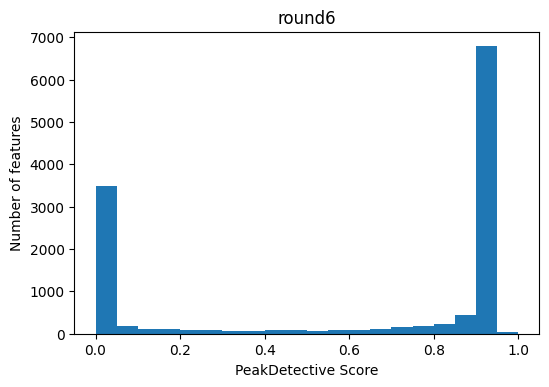

12494 unclassified features remaining
Continue with another iteration? (1=Yes, 0=No): 


 0


1/1 [==============================] - 0s 28ms/step


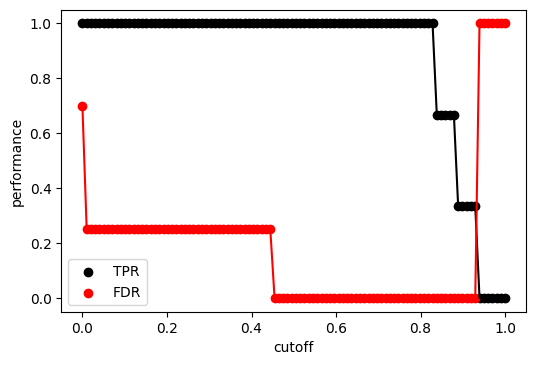

In [151]:
if __name__ == "__main__":
    integ.trainClassifierActive(X,[],[],200,1000,4,1,numVal = 10,numManualPerRound=10,inJupyter=True)

In [43]:
cutoff = 0.5

In [163]:
integ.save(datadir + "active/")

In [135]:
integ.load(datadir + "active/")

In [153]:
y_test_scores_active_syn = integ.classifyMatrix(X_test)

5/5 [==============================] - 0s 2ms/step


In [154]:
if __name__ == "__main__":
    peak_curated,peak_scores,peak_intensities = integ.curatePeaks(raw_data,peakList,threshold=cutoff,align=align)
    peak_curated

generating EICs...
forming matrix |██████████████████████████████████████████████████| 100.0% 
aligning EICs |██████████████████████████████████████████████████| 100.0% 
393/393 [==============================] - 1s 1ms/step
integrating peaks...
integrating peaks |██████████████████████████████████████████████████| 100.0% 


In [155]:
predInt = []
file = files[0]
for index,row in peaks_test.loc[order,:].iterrows():
    predInt.append(peak_intensities.at[row["index"],datadir+file])


In [156]:
predCV = []
trueCV = []
for index,row in peaks_test.loc[order,:].iterrows():
    ints = [peak_intensities.at[row["index"],datadir+file] for file in files]
    cv = 1 - np.std(ints) / np.mean(ints)
    if not np.isnan(cv) and not np.isinf(cv) and cv > 0 and cv < 1:
        predCV.append(cv)
        trueCV.append(row["classification"])

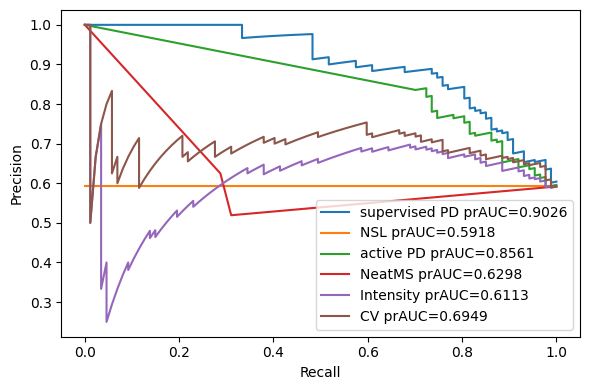

In [157]:
makePRCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=True,label="supervised PD")
makePRCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makePRCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makePRCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makePRCPlot(predCV,trueCV,noSkill=False,label="CV")
plt.tight_layout()
plt.savefig(datadir+"PRC.png",dpi=300)

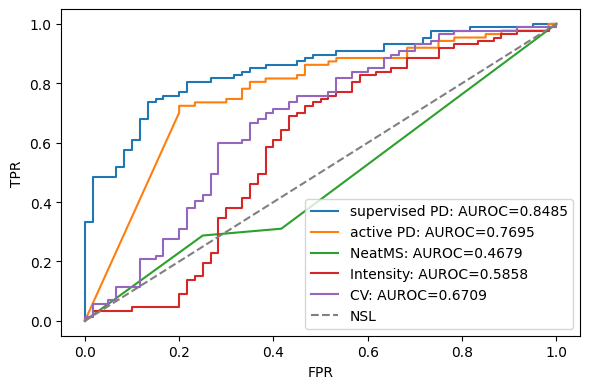

In [158]:
makeROCPlot(y_test_scores_supervised[:,1],y_test[:,1],noSkill=False,label="supervised PD")
makeROCPlot(y_test_scores_active_syn[:,1],y_test[:,1],noSkill=False,label="active PD")
makeROCPlot(y_test_scores_neat_ms,y_test[:,1],noSkill=False,label="NeatMS")
makeROCPlot(predInt,y_test[:,1],noSkill=False,label="Intensity")
makeROCPlot(predCV,trueCV,noSkill=True,label="CV")
plt.tight_layout()
plt.savefig(datadir+"ROC.png",dpi=300)

In [159]:
acc_results = {"active PD":{},"NeatMS":{}}

for metricFunc,name in zip([met.accuracy_score,met.precision_score,met.recall_score],["accuracy","precision","recall"]):
    acc_results["active PD"][name] = metricFunc(y_test[:,1],y_test_scores_active_syn[:,1] > cutoff)
    acc_results["NeatMS"][name] = metricFunc(y_test[:,1],y_test_scores_neat_ms > 0.25)

acc_results = pd.DataFrame.from_dict(acc_results,orient="index")
acc_results.to_csv(datadir + "accuracy_results.csv")
acc_results

accuracy  precision    recall
active PD  0.714286   0.731959  0.816092
NeatMS     0.421769   0.519231  0.310345

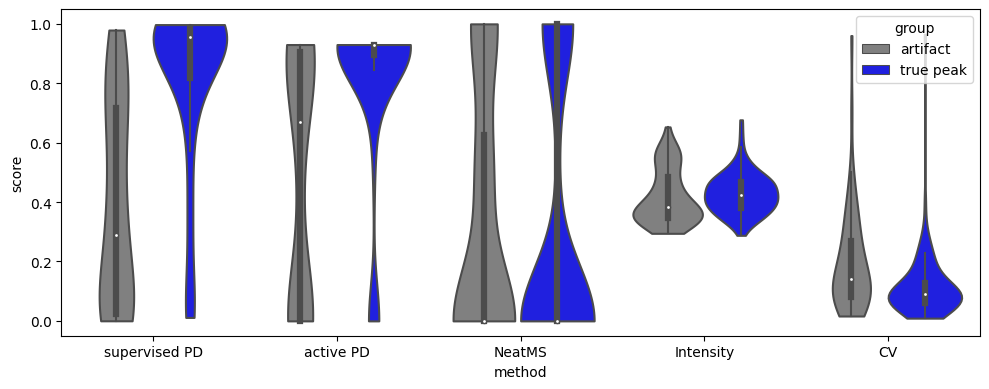

In [160]:
plt_df = {}
for x in range(len(y_test)):
    if y_test[x][1] > cutoff:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"true peak","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"true peak","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"true peak","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"true peak","score":np.log10(predInt[x]+2)/10}
    else:
        plt_df[len(plt_df)] = {"method":"supervised PD","group":"artifact","score":y_test_scores_supervised[x][1]}
        plt_df[len(plt_df)] = {"method":"active PD","group":"artifact","score":y_test_scores_active_syn[x][1]}
        plt_df[len(plt_df)] = {"method":"NeatMS","group":"artifact","score":y_test_scores_neat_ms[x]}
        plt_df[len(plt_df)] = {"method":"Intensity","group":"artifact","score":np.log10(predInt[x]+2)/10}
for x in range(len(predCV)):
    if trueCV[x] > 0.5:
        plt_df[len(plt_df)] = {"method":"CV","group":"true peak","score":1-predCV[x]}
    else:
        plt_df[len(plt_df)] = {"method":"CV","group":"artifact","score":1-predCV[x]}

plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
plt.figure(figsize=(10,4))
sb.violinplot(data=plt_df,x="method",y="score",hue="group",cut=0,palette={"true peak":"blue","artifact":"grey"})
#sb.boxplot(data=plt_df,x="method",y="score",hue="group",fliersize=0,palette={"true peak":"blue","artifact":"grey"})
#sb.barplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"blue","artifact":"grey"})
#sb.swarmplot(data=plt_df,x="method",y="score",hue="group",palette={"true peak":"black","artifact":"black"},dodge=True,s=1,legend=False)
plt.tight_layout()
plt.savefig(datadir+"bar.png",dpi=300)

In [161]:
y = integ.classifyMatrix(X)

393/393 [==============================] - 1s 1ms/step


In [164]:
y_labeled_pred = integ.classifyMatrix(X_labeled)

8/8 [==============================] - 0s 3ms/step


(12564,) (12564, 60)


C:\Users\Ethan\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


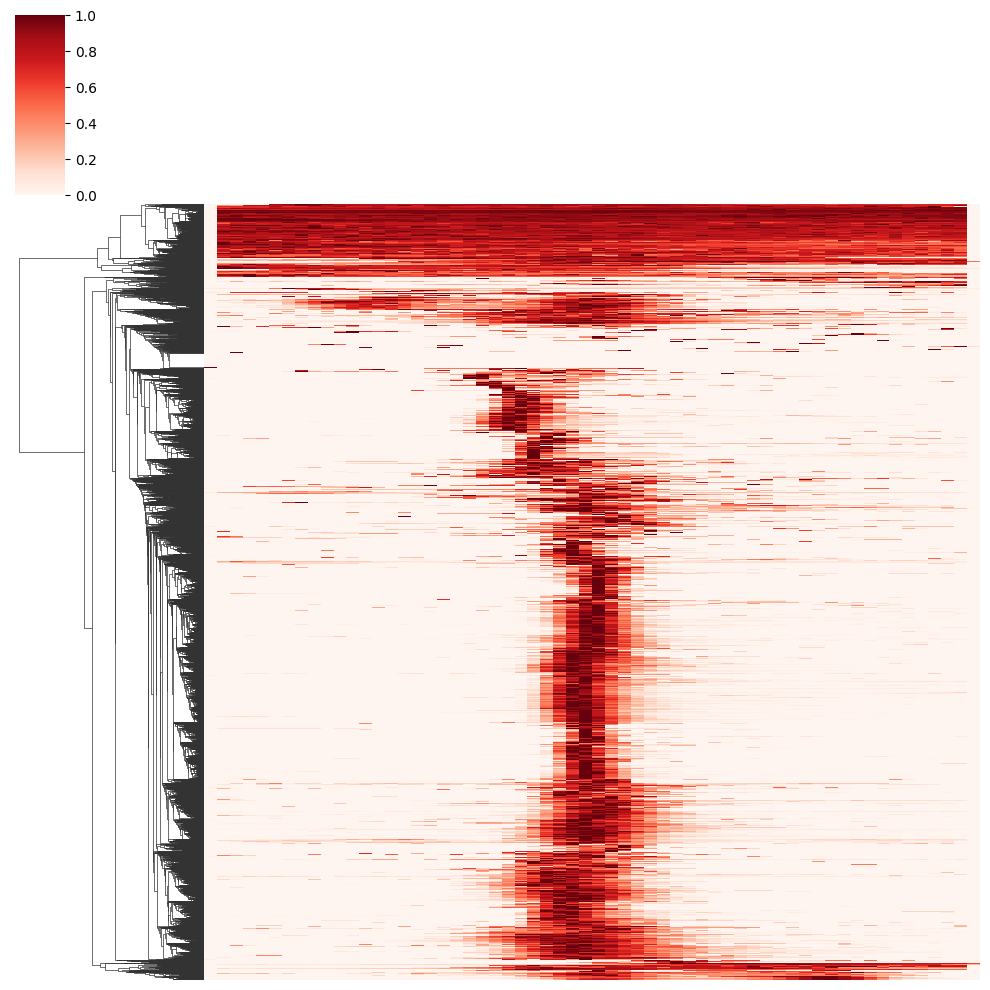

In [165]:

tmp = deepcopy(X)
norm = np.max(tmp,axis=1)
print(norm.shape,tmp.shape)
norm[norm < 1e-6] = 1.0
tmp = np.array([x/n for x,n in zip(tmp,norm)])
tmp = pd.DataFrame(tmp)
f = sb.clustermap(tmp,col_cluster=False,yticklabels=False,cmap="Reds",xticklabels=False)
#f = sb.clustermap(PeakDetective.normalizeMatrix(X[:int(len(peakList)/10)]),col_cluster=False,yticklabels=False,cmap="magma",standard_scale=0,vmin=0.0,vmax=1.0,row_colors=row_colors)
f.savefig(datadir + "heatmap_all.png",dpi=300)

(250,) (250, 60)


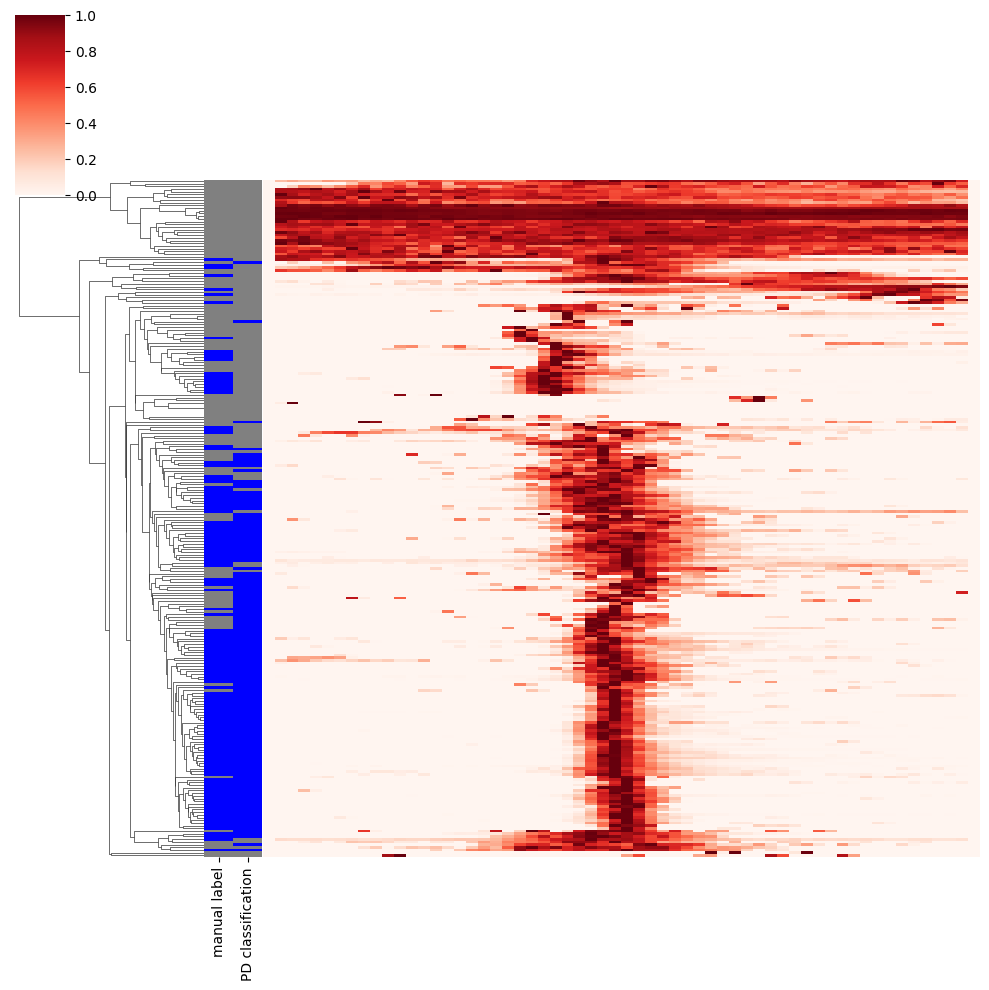

In [166]:
def tmp(val):
    if val > cutoff:
        return "blue"
    return "grey"

row_colors = pd.DataFrame({"manual label": [tmp(x) for x in y_labeled[:,1]], "PD classification": [tmp(x) for x in y_labeled_pred[:,1]]}, index=list(range(len(X_labeled))))

tmp = deepcopy(X_labeled)
norm = np.max(tmp,axis=1)
print(norm.shape,tmp.shape)
norm[norm < 1e-6] = 1.0
tmp = np.array([x/n for x,n in zip(tmp,norm)])
tmp = pd.DataFrame(tmp)
f = sb.clustermap(tmp,col_cluster=False,yticklabels=False,cmap="Reds",row_colors=row_colors,xticklabels=False)
#f = sb.clustermap(PeakDetective.normalizeMatrix(X[:int(len(peakList)/10)]),col_cluster=False,yticklabels=False,cmap="magma",standard_scale=0,vmin=0.0,vmax=1.0,row_colors=row_colors)
f.savefig(datadir + "heatmap.png",dpi=300)

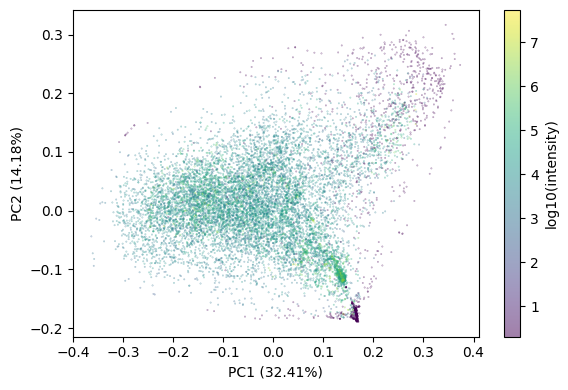

In [167]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
plt.scatter(loads[:,0],loads[:,1],c=np.log10(np.array([np.max([2, PeakDetective.integratePeak(x)]) for x in X])),s=.1,alpha=.5)
plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))
plt.colorbar(label="log10(intensity)")
plt.tight_layout()
plt.savefig(datadir + "pca_int.png",dpi=300)

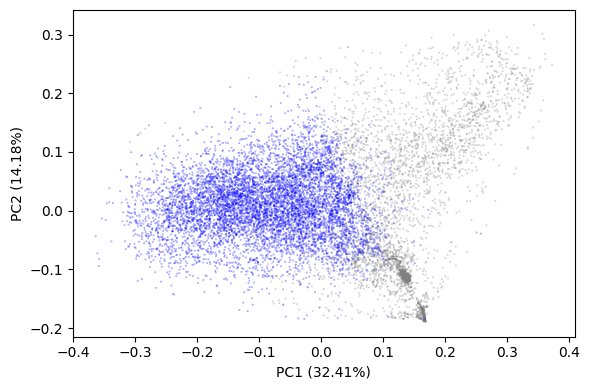

In [168]:
pca = PCA(2)
loads = pca.fit_transform(PeakDetective.normalizeMatrix(X))
colormap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
def getColor(v):
    if v > cutoff:
        return "blue"
    else:
        return "grey"
colors = [getColor(x) for x in y[:,1]]
#plt.scatter(loads[:,0],loads[:,1],c=y[:,1],s=.1,alpha=.5,cmap=colormap)
plt.scatter(loads[:,0],loads[:,1],c=colors,s=.1,alpha=.5)

plt.xlabel("PC1 (" + str(np.round(100*pca.explained_variance_ratio_[0],2)) + "%)")
plt.ylabel("PC2 (" + str(np.round(100*pca.explained_variance_ratio_[1],2)) + "%)")
#plt.xlim((-.5,.5))

#plt.colorbar(label="PeakDetective Score")
plt.tight_layout()
plt.savefig(datadir + "pca_pd.png",dpi=300)

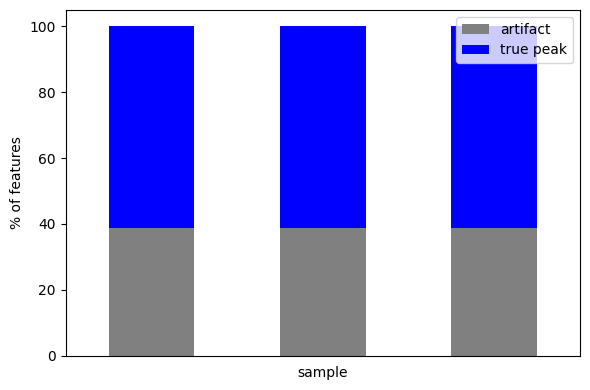

In [169]:
df = {}
for file in files:
    for index,row in peak_curated.iterrows():
        if row[datadir + file] > cutoff:
            df[len(df)] = {"sample":file,"classification":"true peak"}
        else:
            df[len(df)] = {"sample":file,"classification":"artifact"}

df = pd.DataFrame.from_dict(df,orient="index")

def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ 100*len(df[(df[rows]==value) & (df[columns]==key)]) / len(df[df[rows]==value]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf


aggregate('sample','classification',df).plot(kind='bar',stacked=True,color=["grey","blue"])
plt.xticks([],[])
plt.ylabel("% of features")
plt.tight_layout()
plt.savefig(datadir + "bar_pd_arts.png",dpi=300)

['B1_NIST1950_1_6540.mzML', 'B1_NIST1950_2_6540.mzML', 'B1_NIST1950_3_6540.mzML']


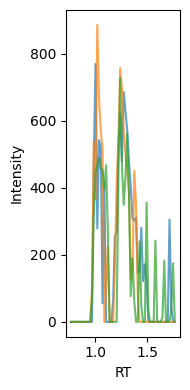

In [170]:


file = files[0]
print(files)
inds = list(peak_curated.index.values)
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] > cutoff:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "true_peak_example.png",dpi=300)


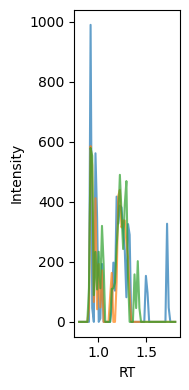

In [171]:
rd.shuffle(inds)
plt.figure(figsize=(2,4))
for i in inds:
    if peak_curated.at[i,datadir + file] < cutoff:
        plot_overlayedEIC(raw_data,peak_curated.at[i,"mz"],peak_curated.at[i,"rt"]-.5,peak_curated.at[i,"rt"]+.5,resolution=resolution,alpha=0.7)
        plt.xlabel("RT")
        plt.ylabel("Intensity")
        break
plt.tight_layout()
plt.savefig(datadir + "artifact_example.png",dpi=300)

In [172]:
true = []
pred = []
file = files[0]
fps = []
fns = []
for index,row in peakList_labeled.iterrows():
    if peak_curated.at[index,datadir + file] > 0.5:
        pred.append(1.0)
        if row["classification"] < 0.5:
            fps.append(index)
    else:
        pred.append(0.0)
        if row["classification"] > .5:
            fns.append(index)
    true.append(row["classification"])
    
confusion_matrix(true,pred)

array([[150,  78],
       [ 54, 218]], dtype=int64)

C:\Users\Ethan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


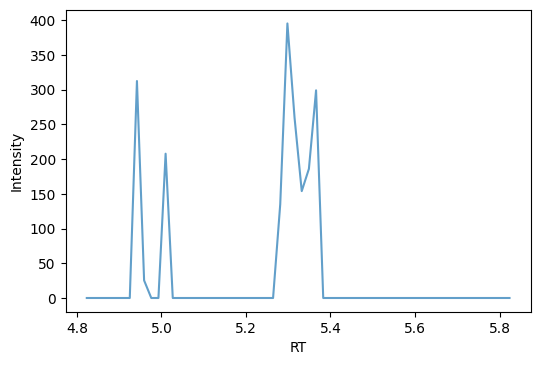

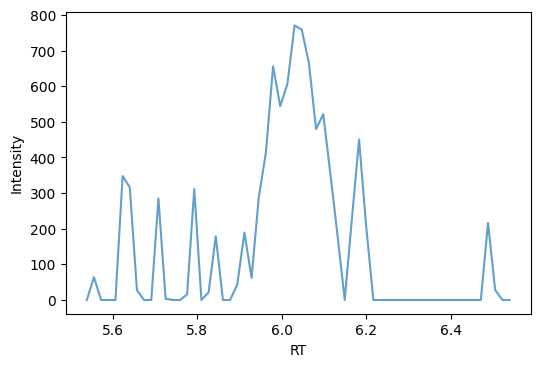

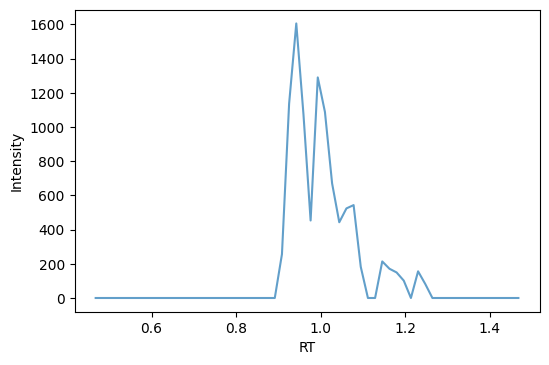

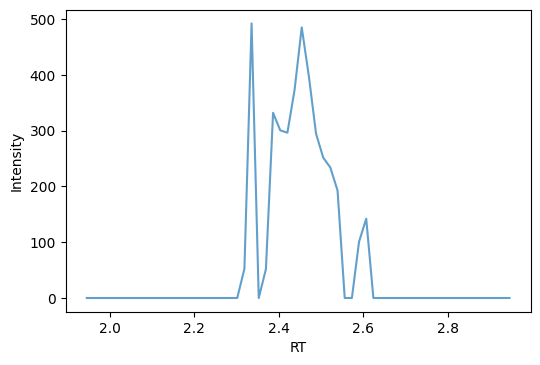

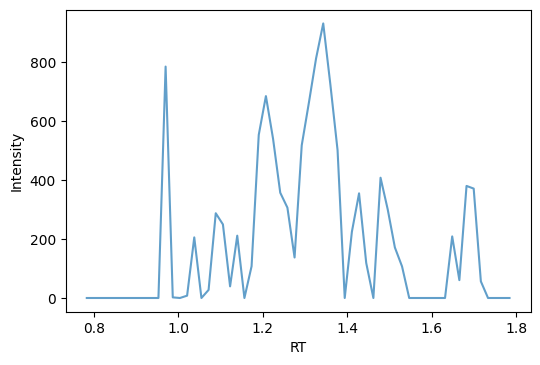

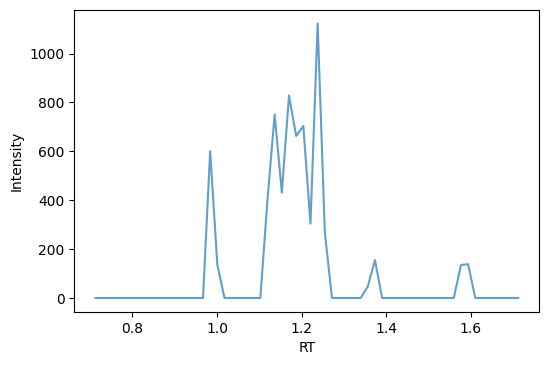

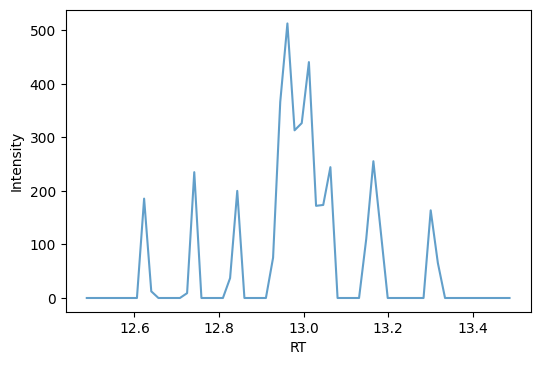

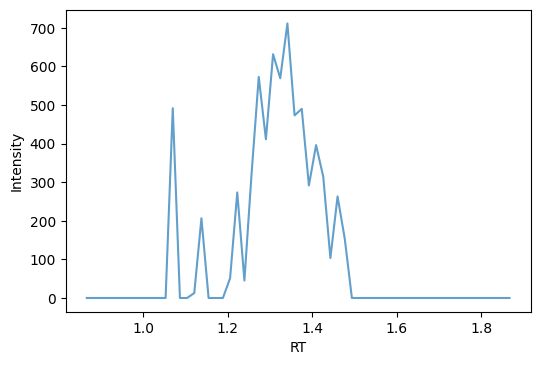

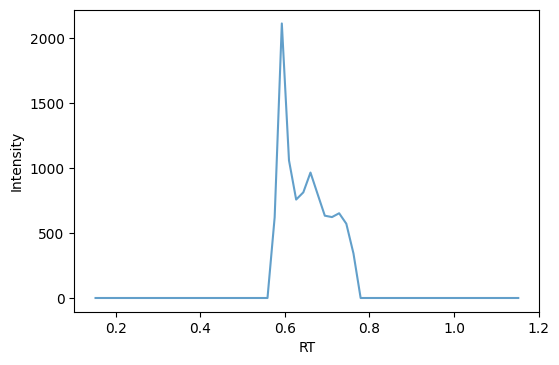

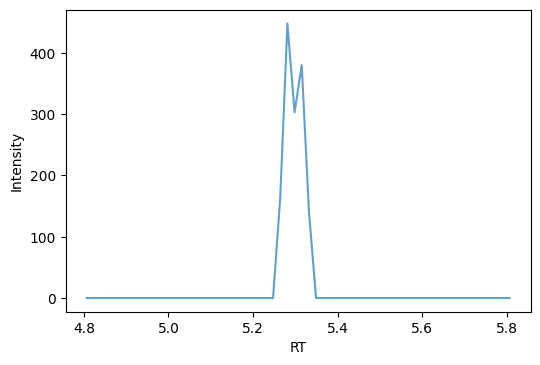

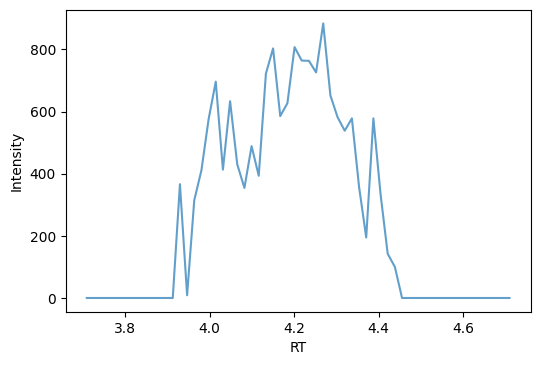

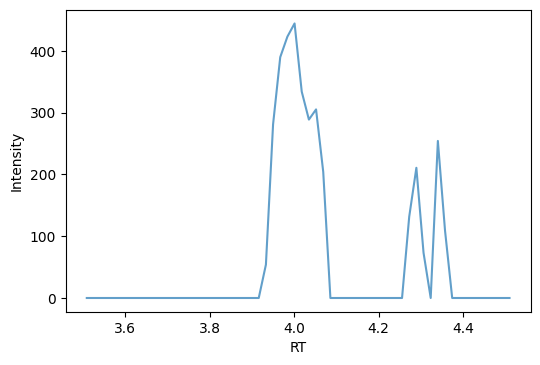

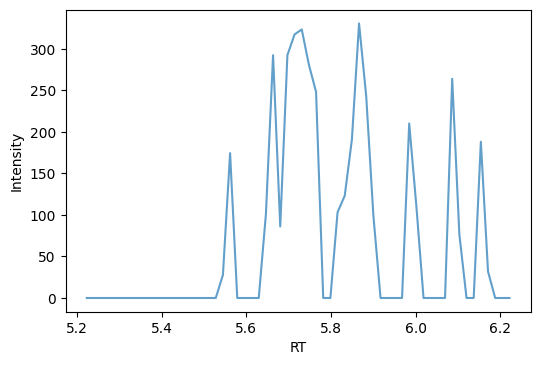

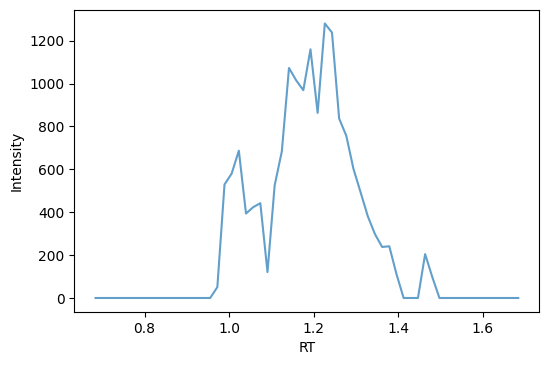

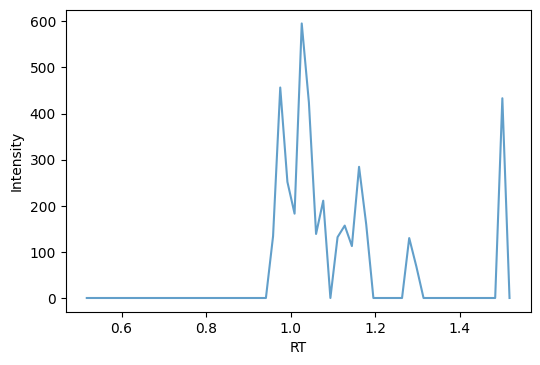

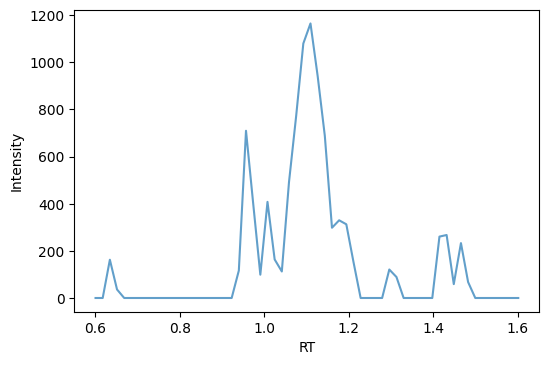

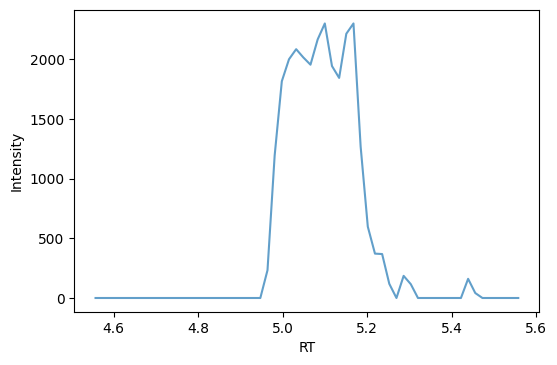

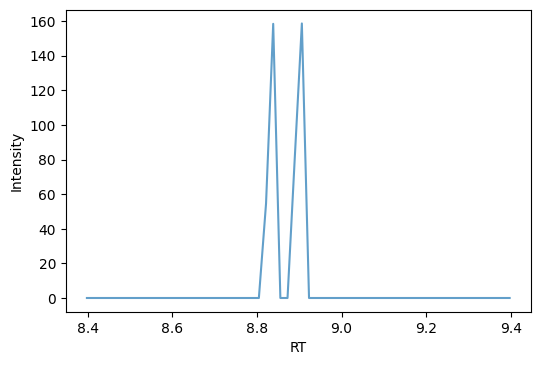

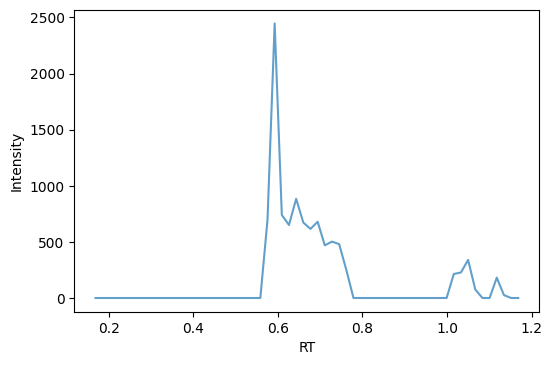

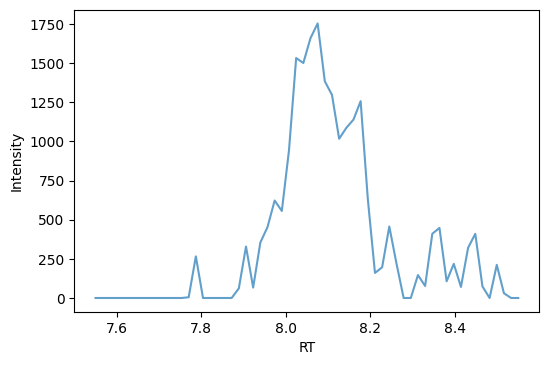

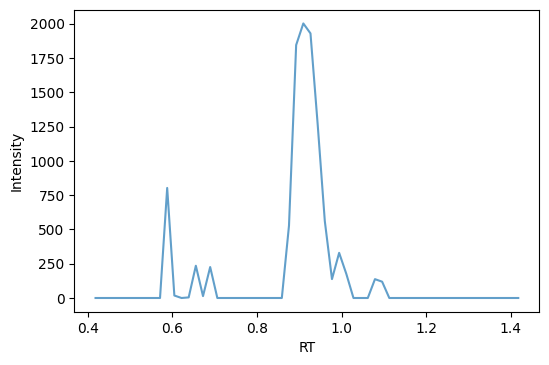

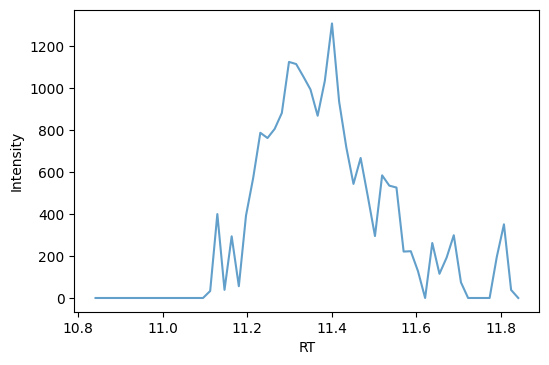

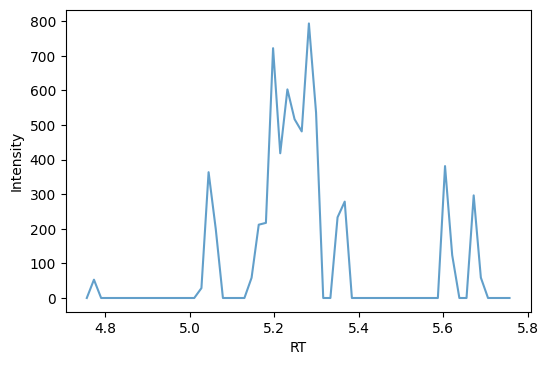

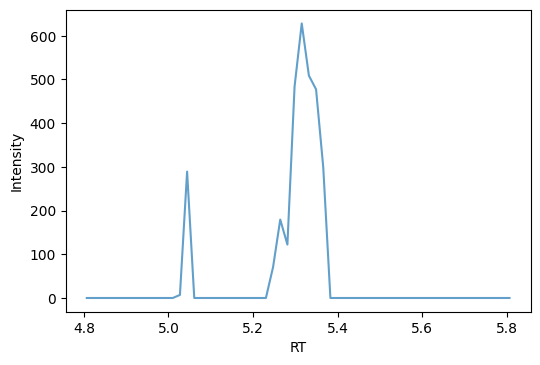

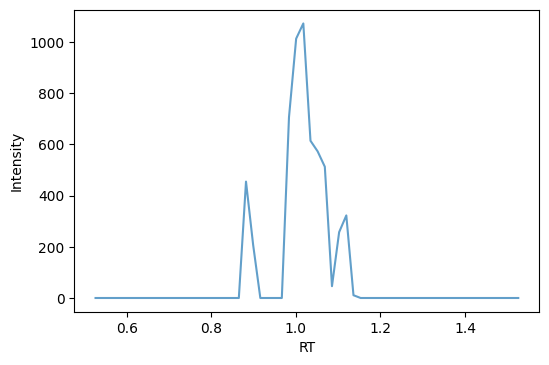

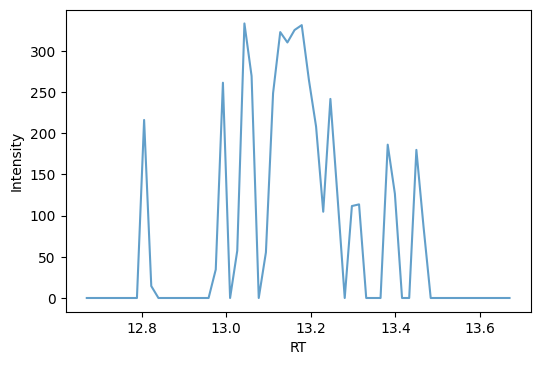

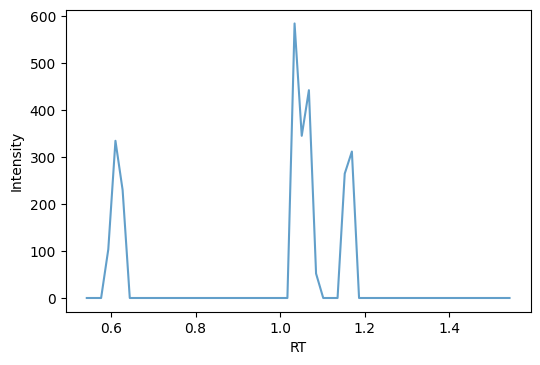

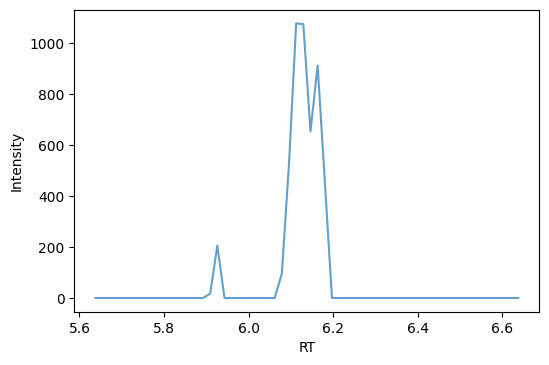

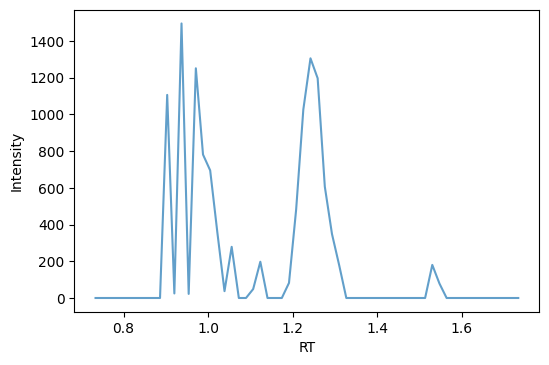

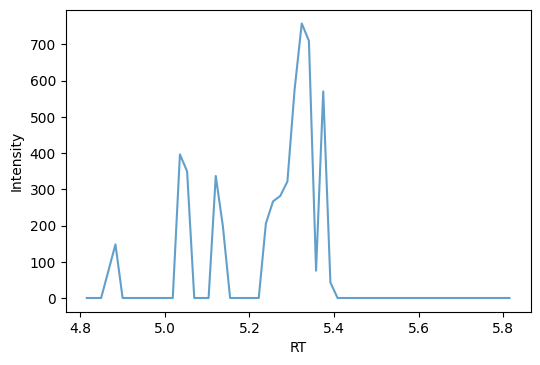

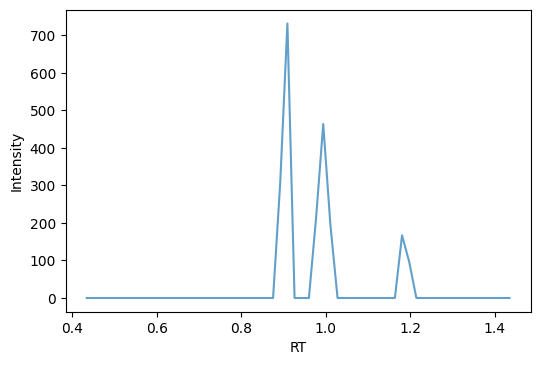

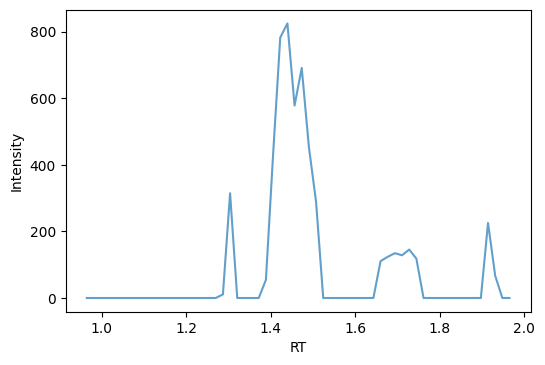

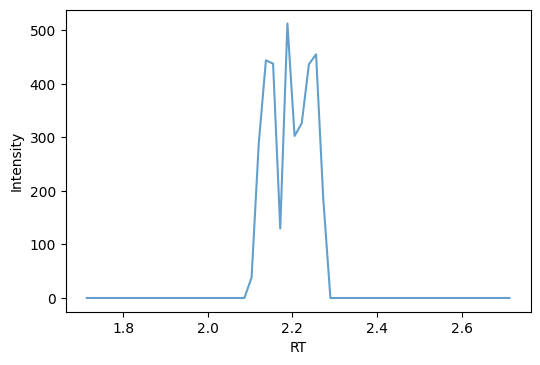

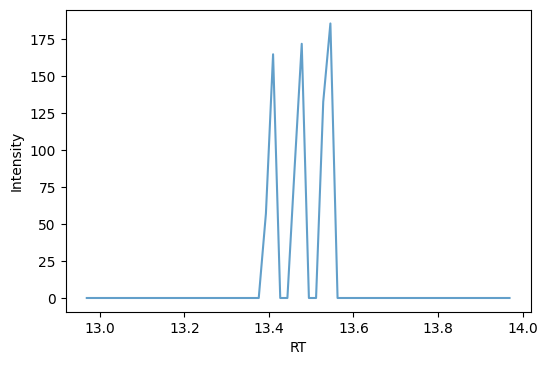

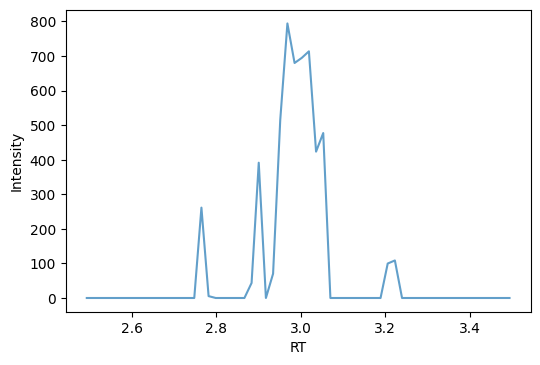

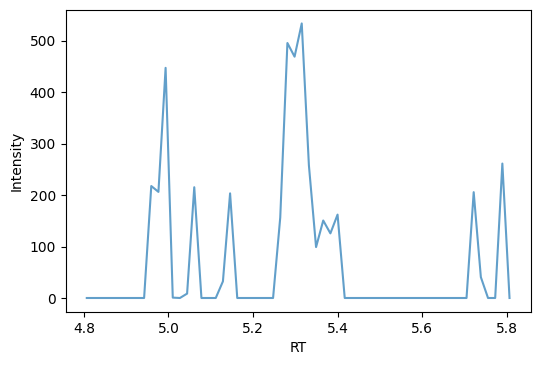

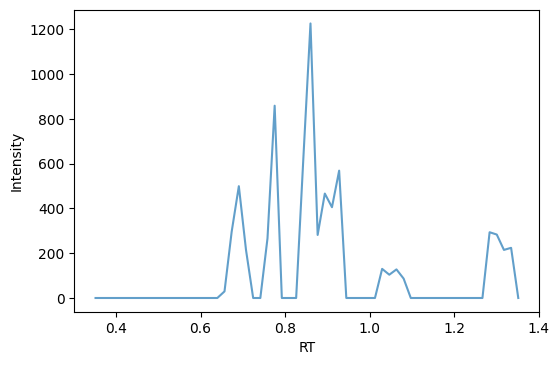

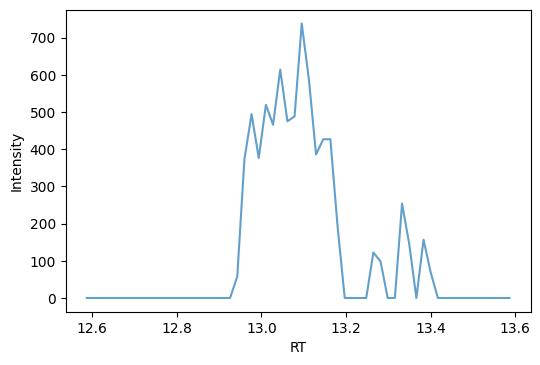

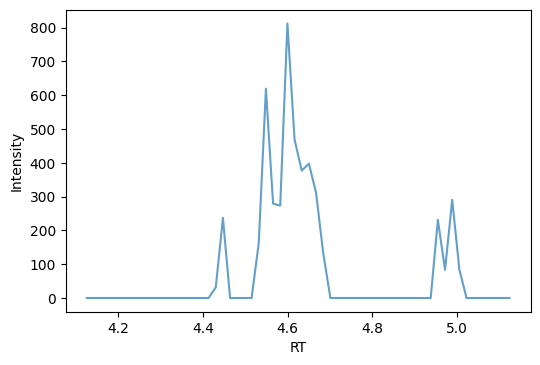

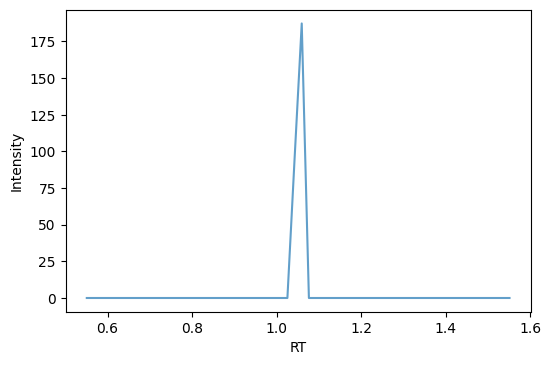

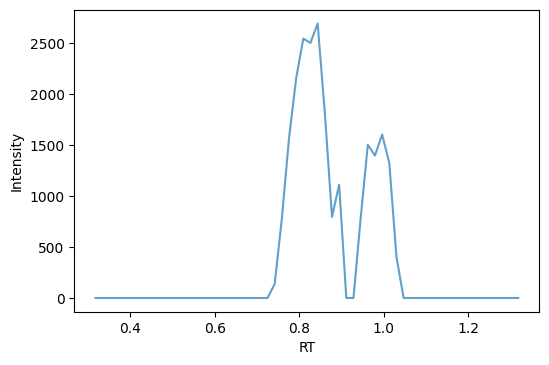

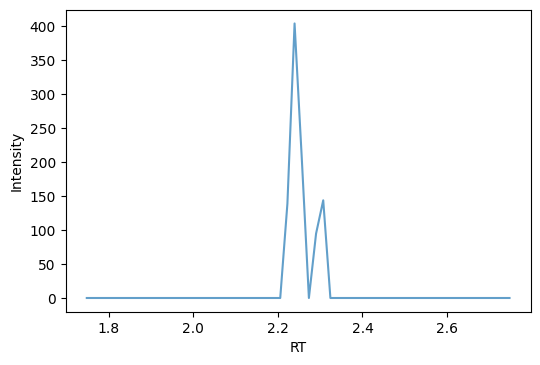

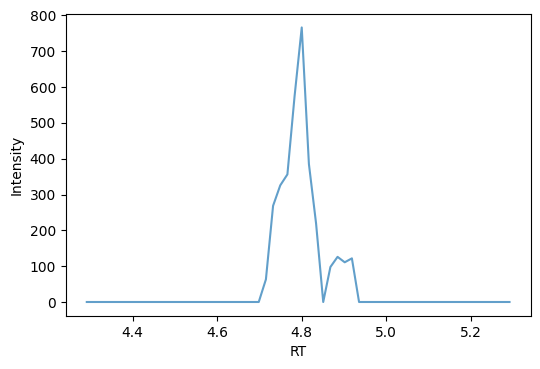

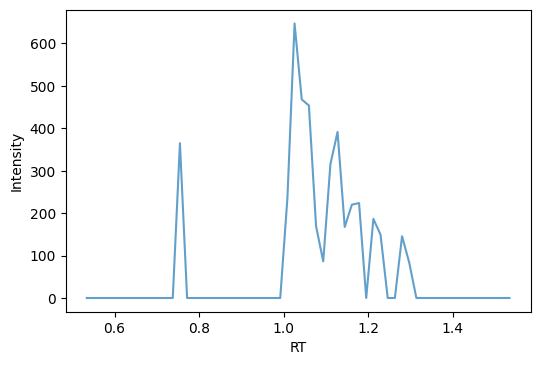

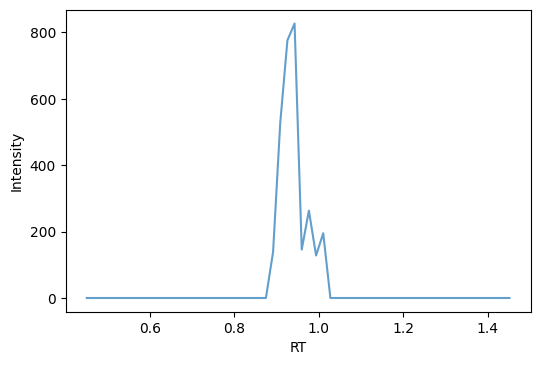

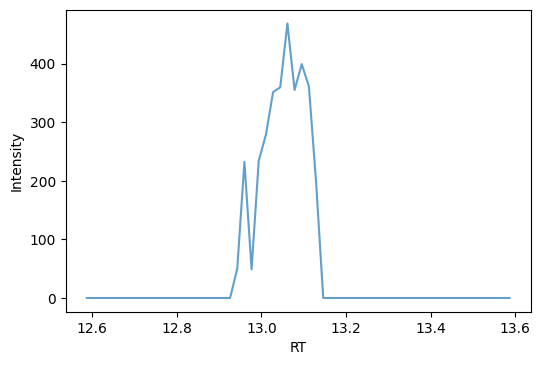

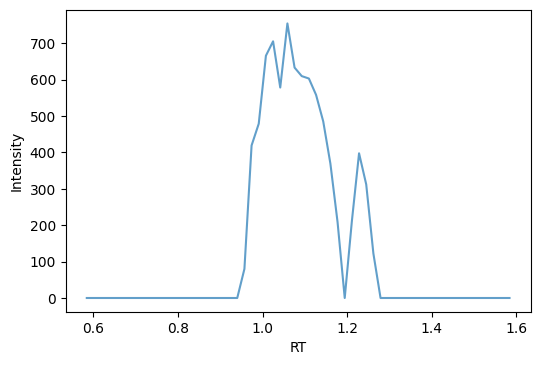

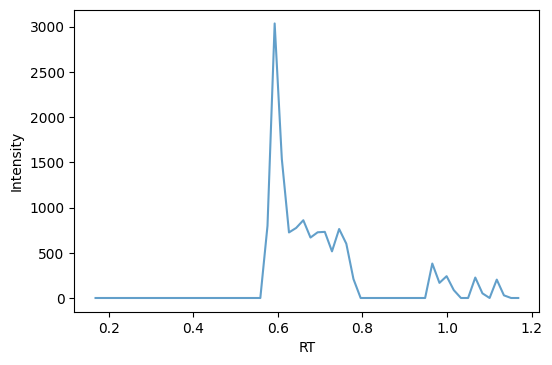

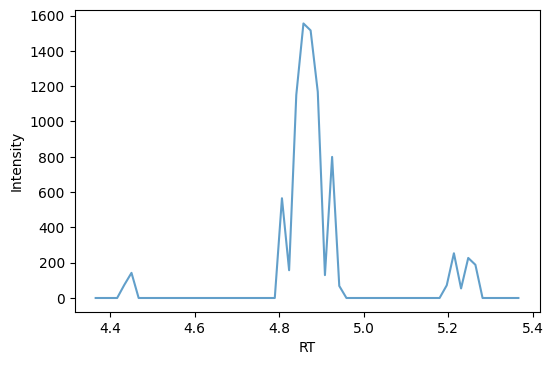

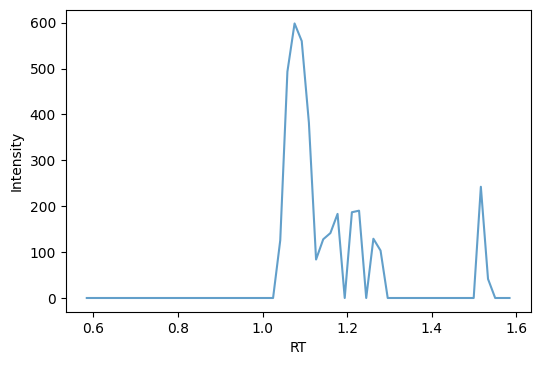

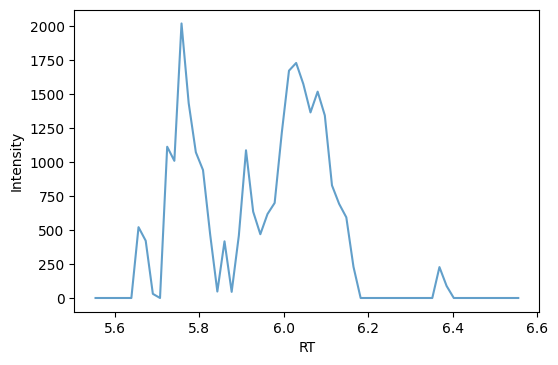

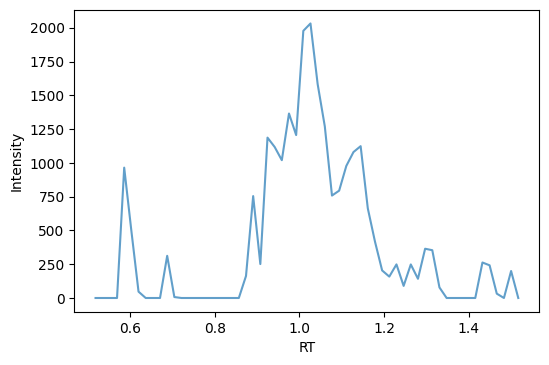

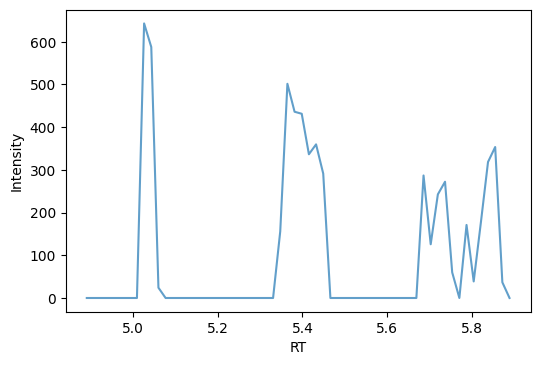

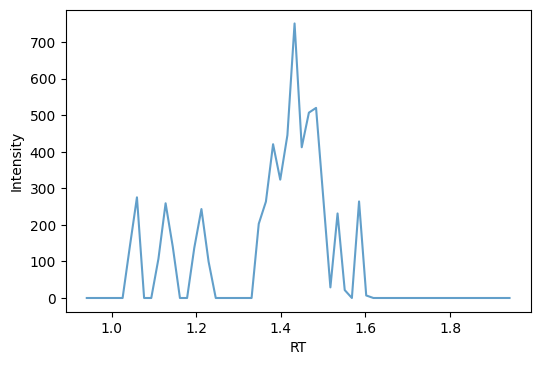

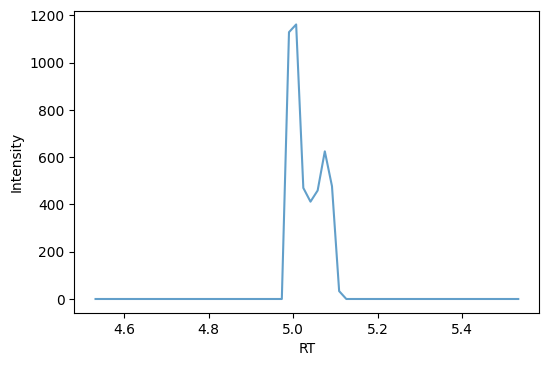

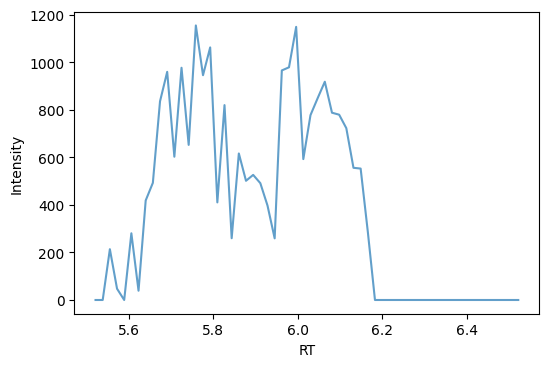

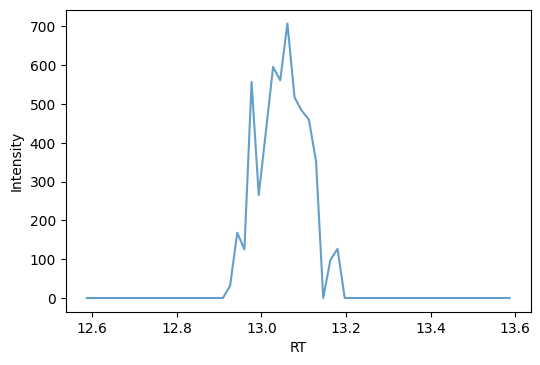

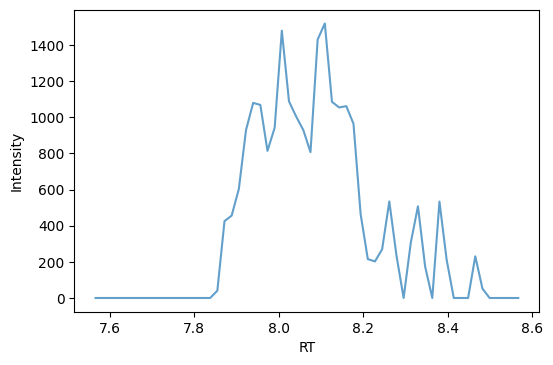

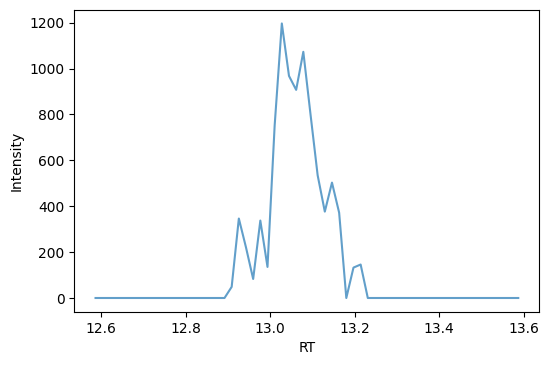

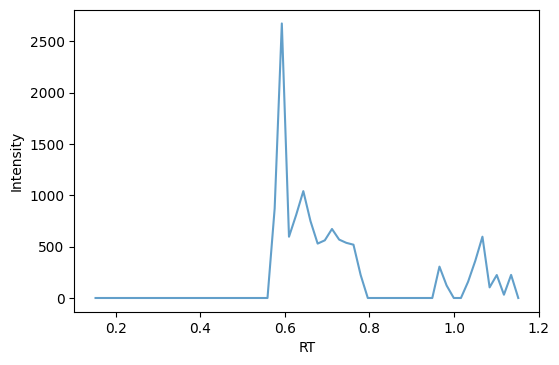

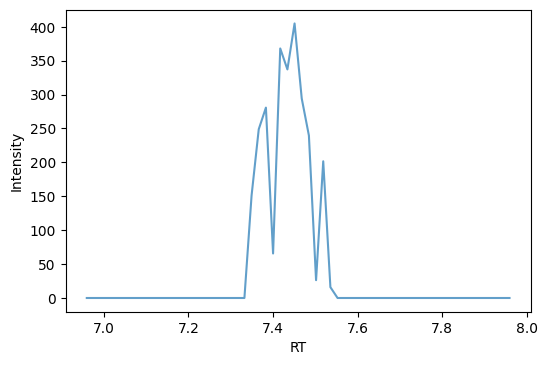

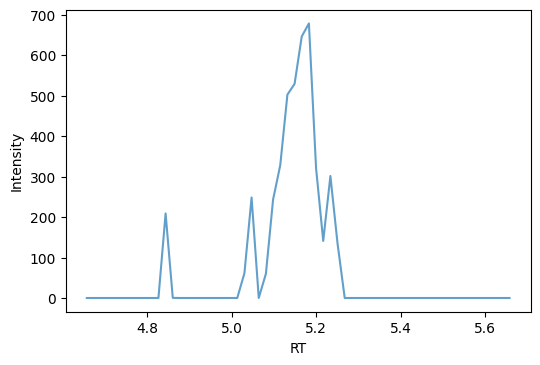

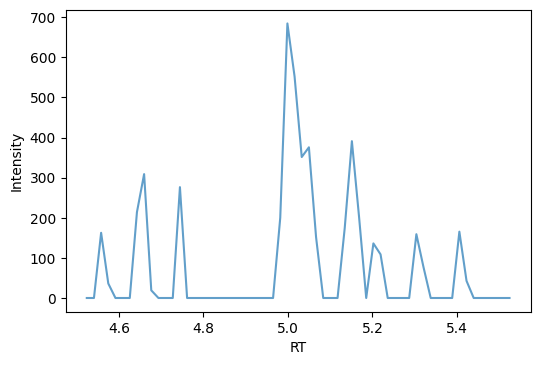

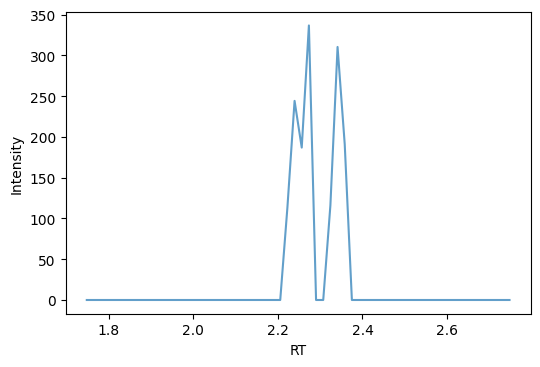

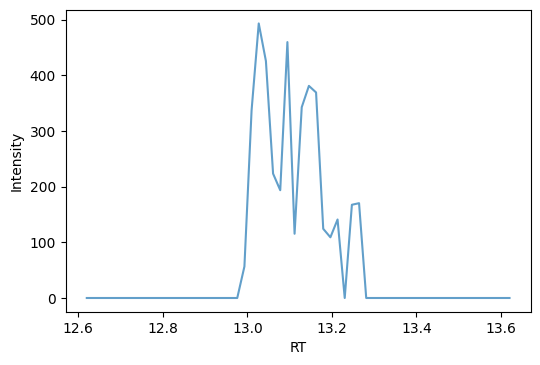

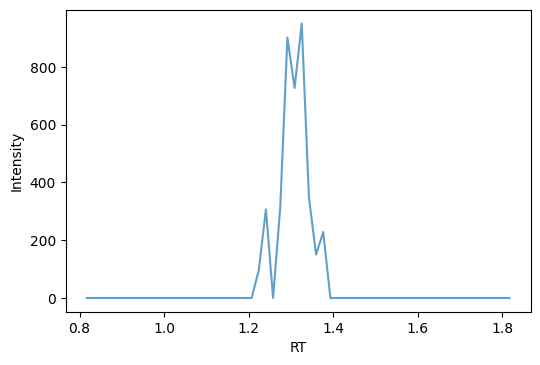

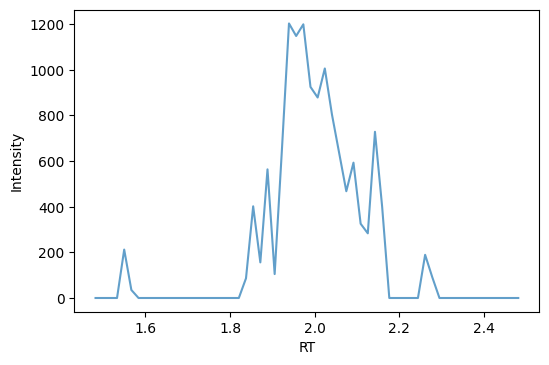

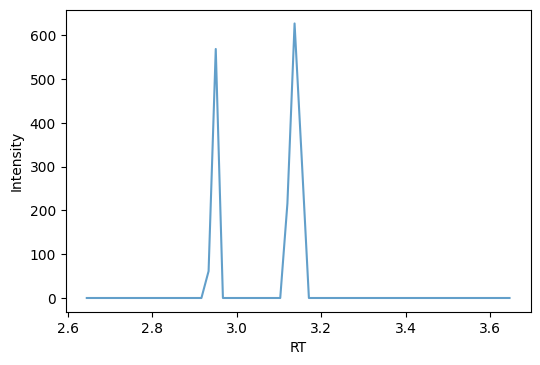

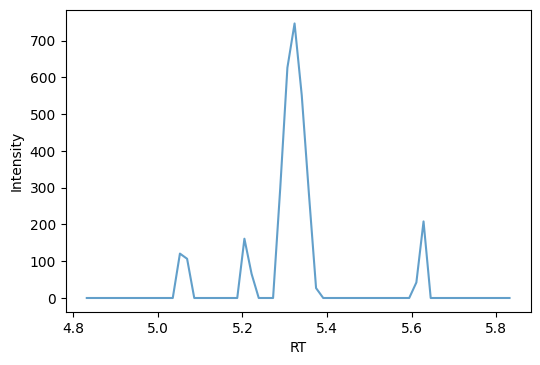

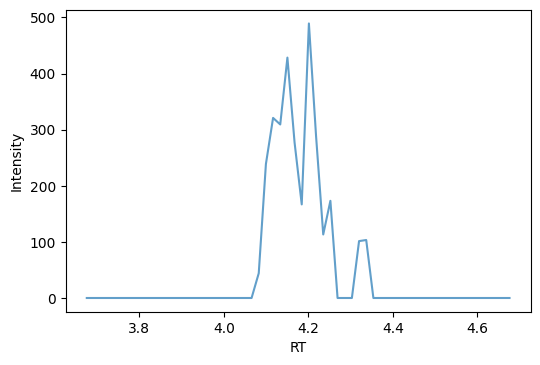

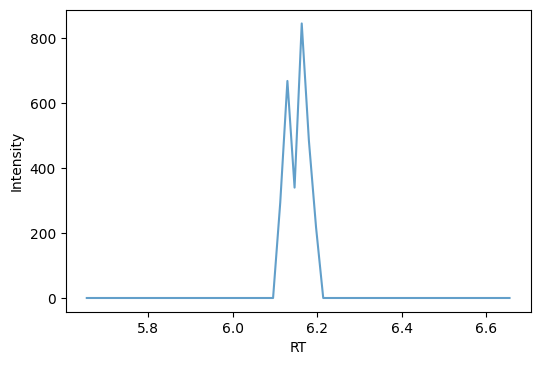

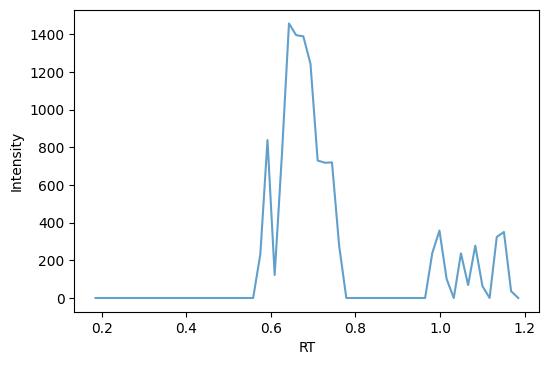

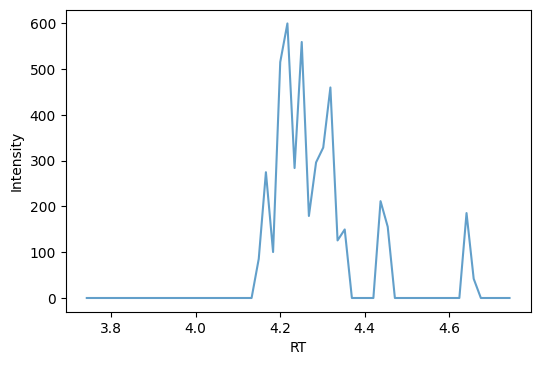

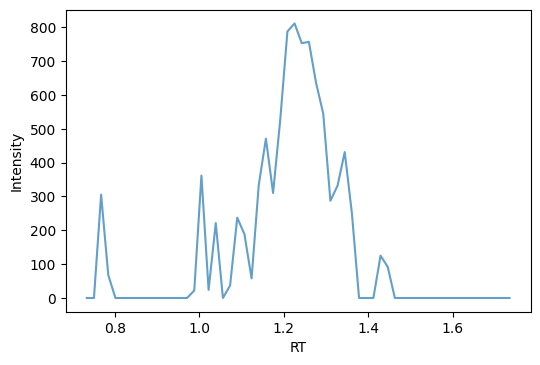

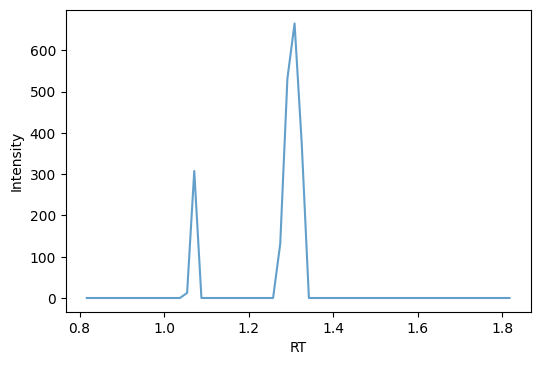

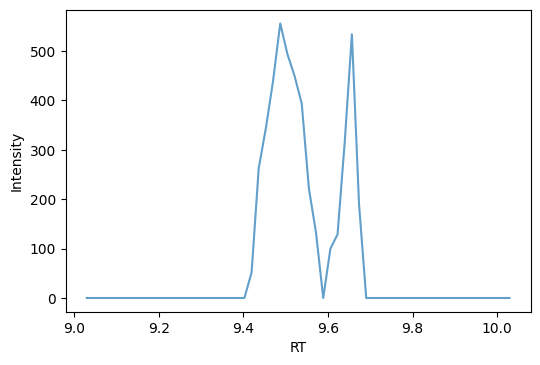

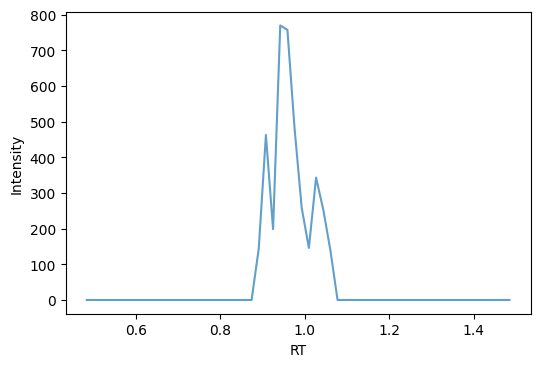

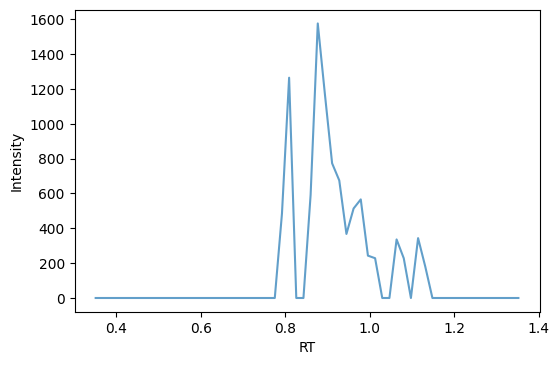

<Figure size 600x400 with 0 Axes>

In [173]:
for ind in fps:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

C:\Users\Ethan\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """


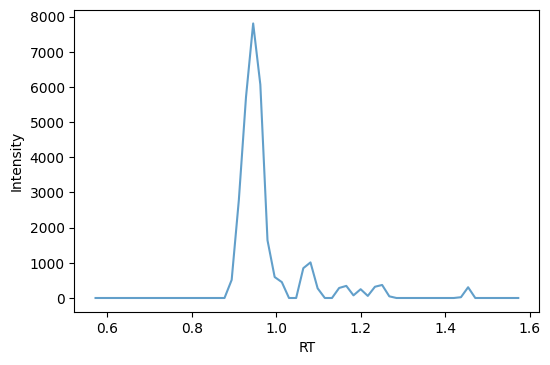

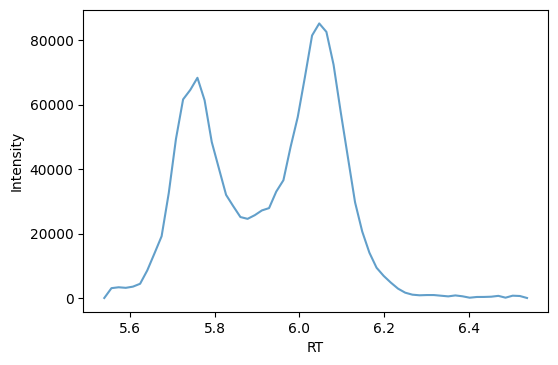

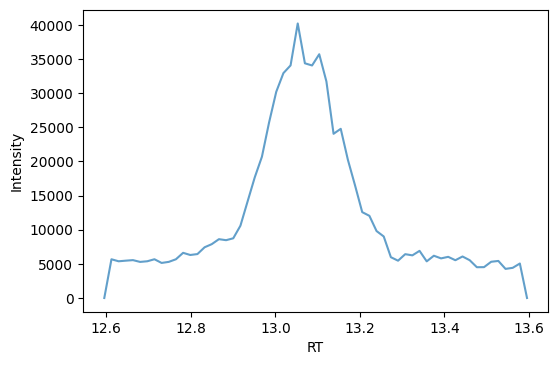

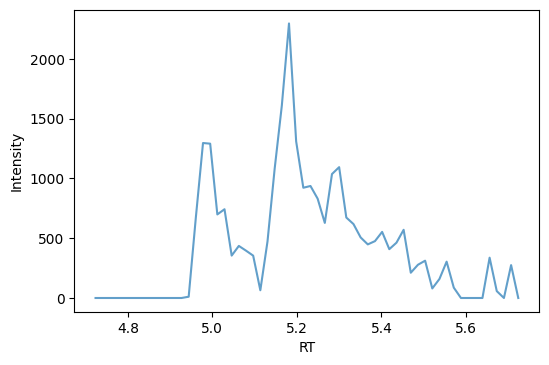

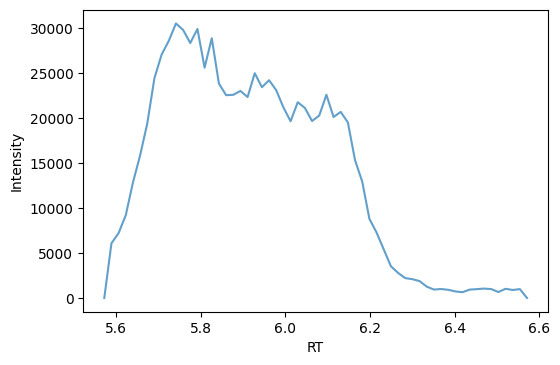

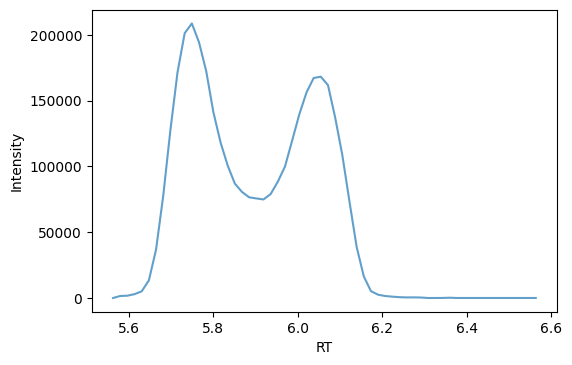

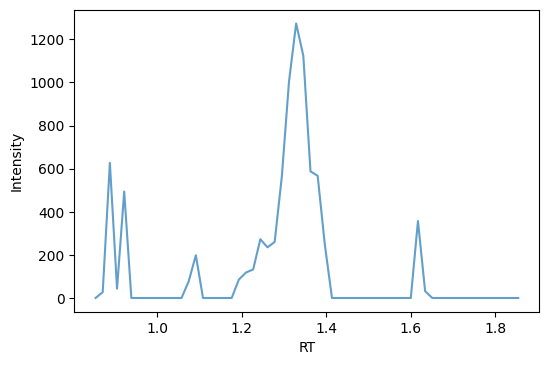

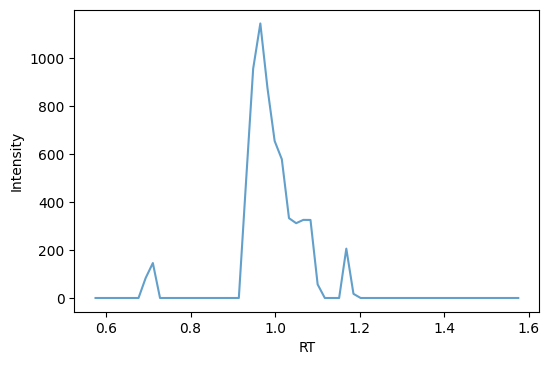

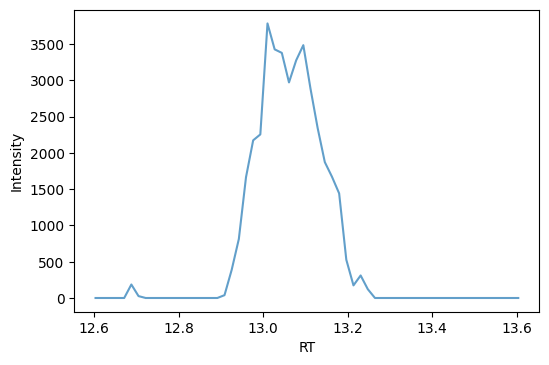

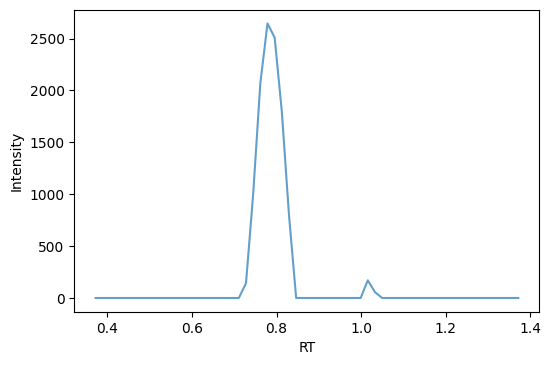

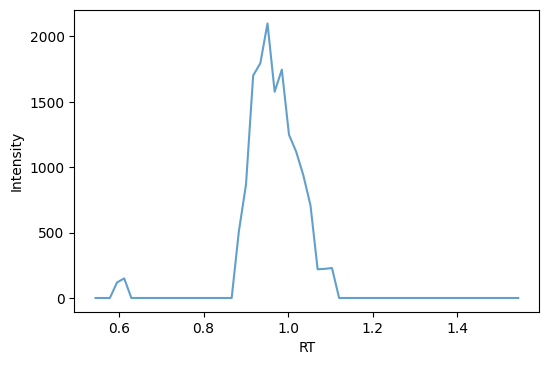

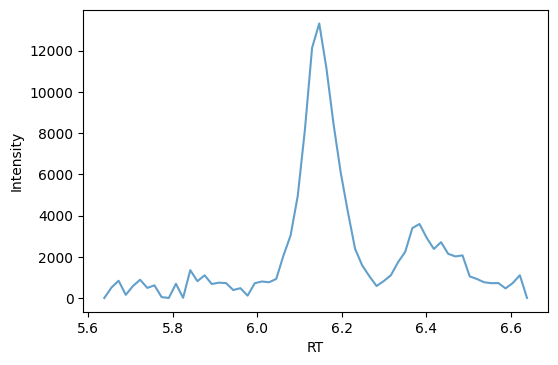

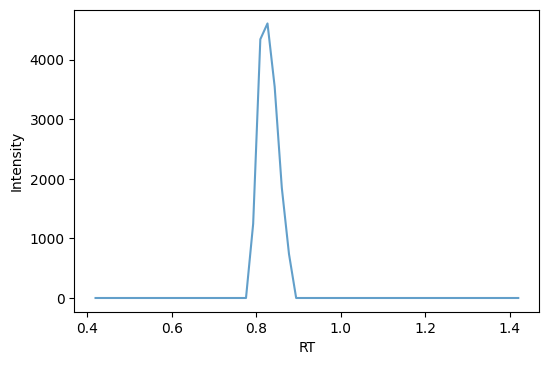

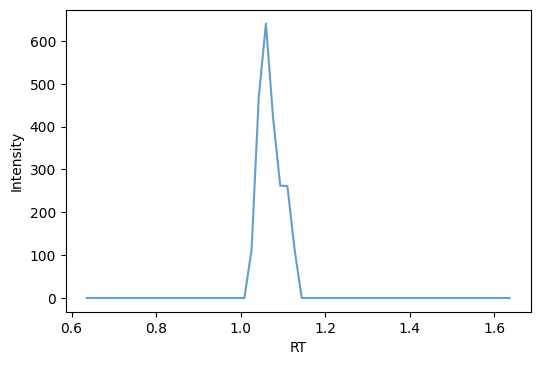

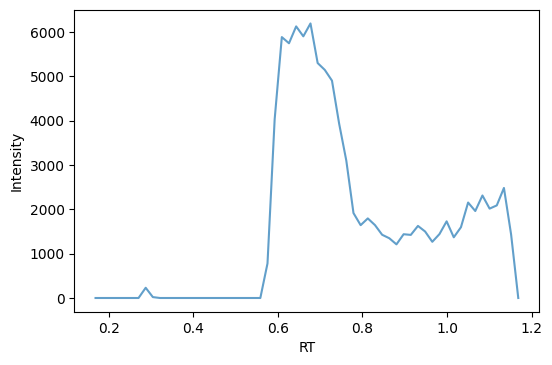

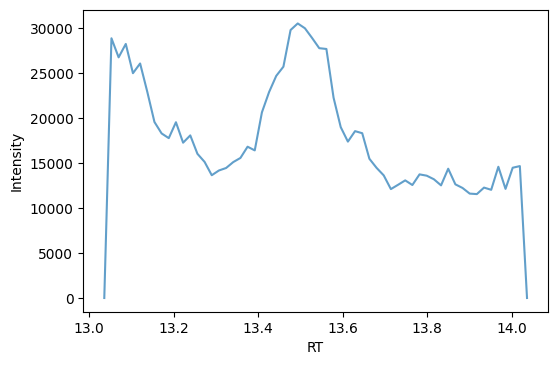

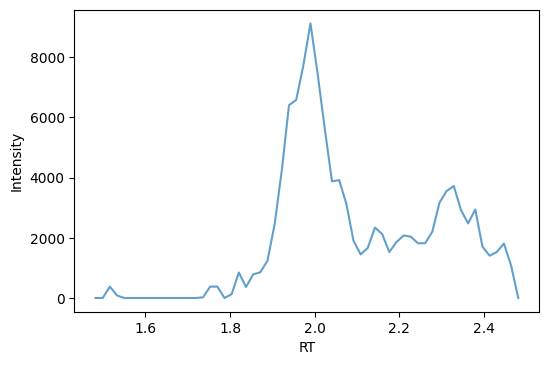

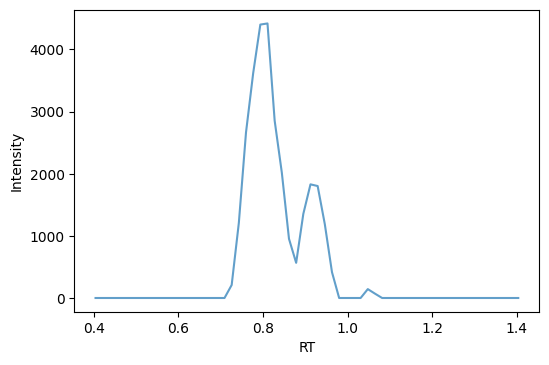

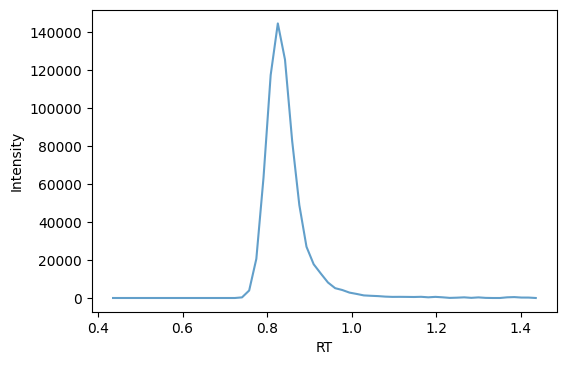

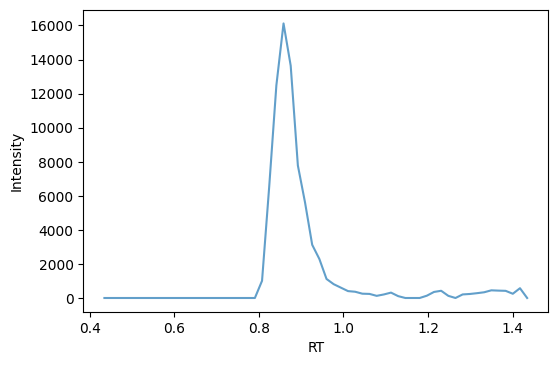

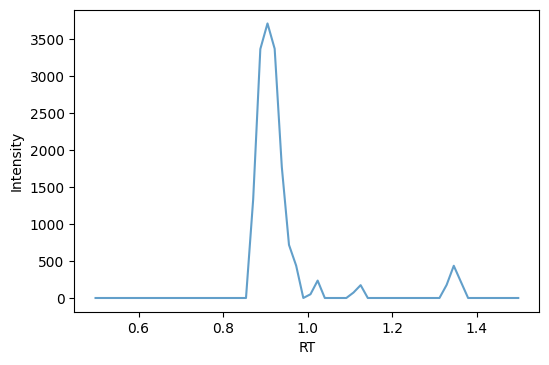

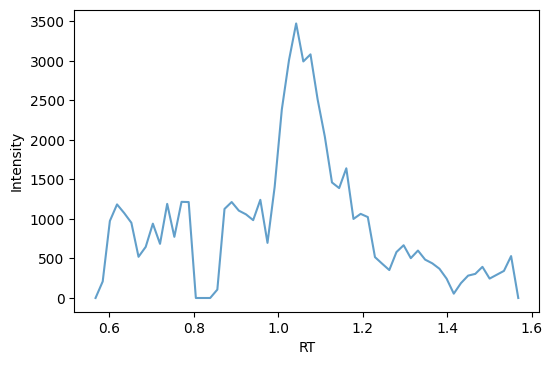

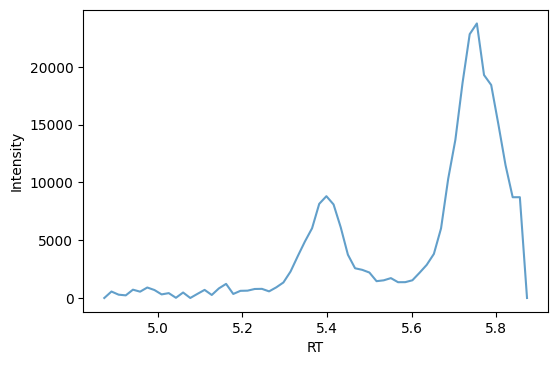

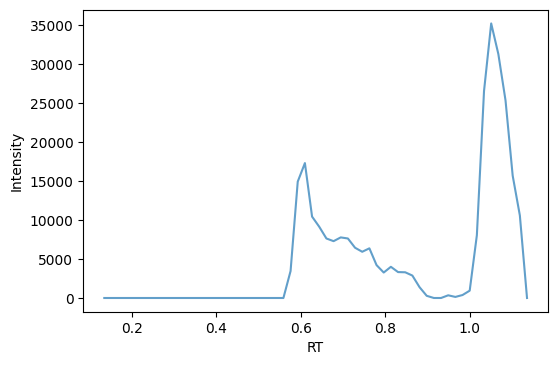

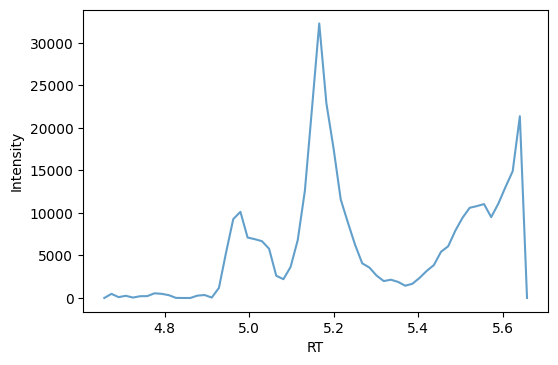

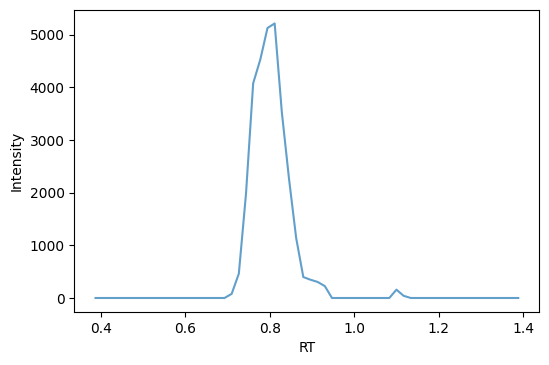

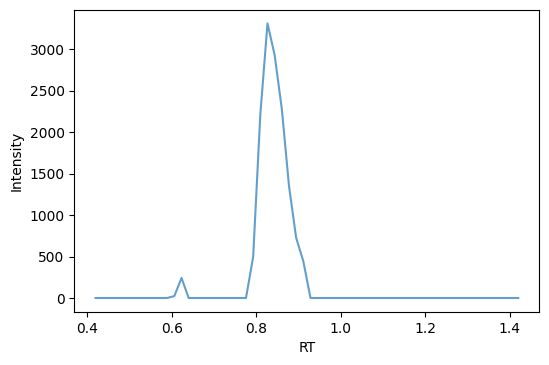

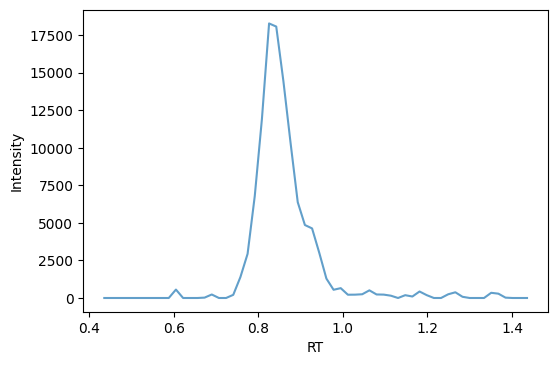

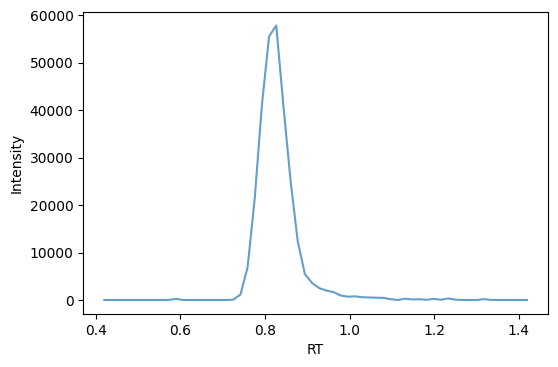

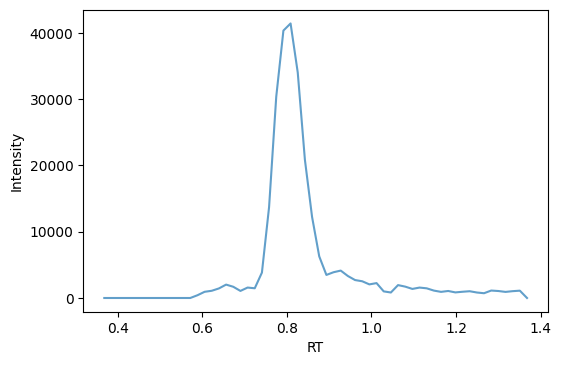

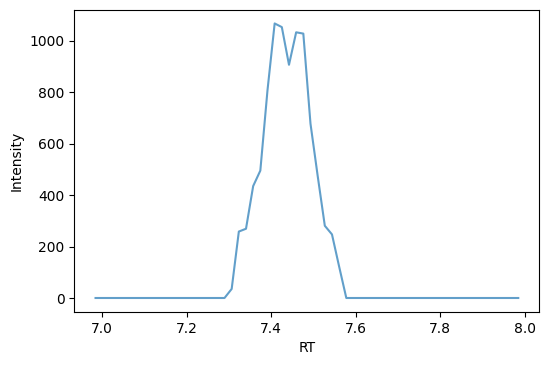

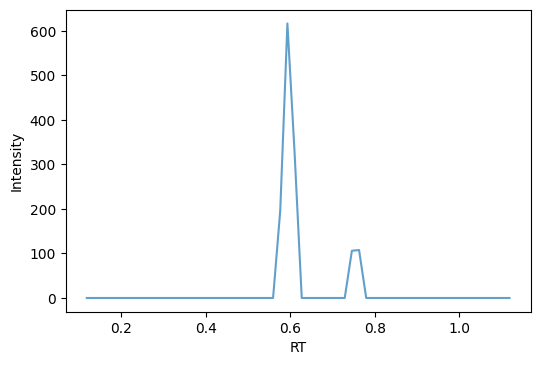

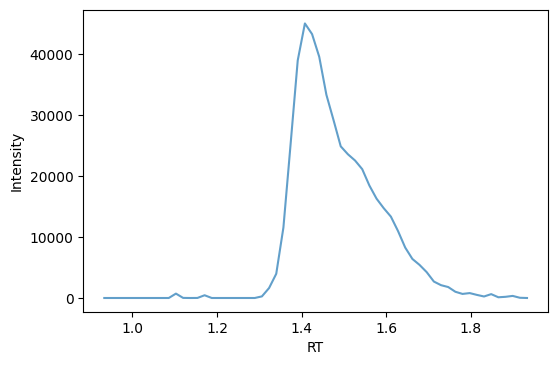

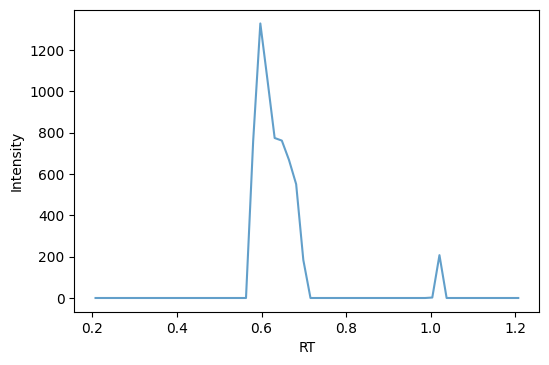

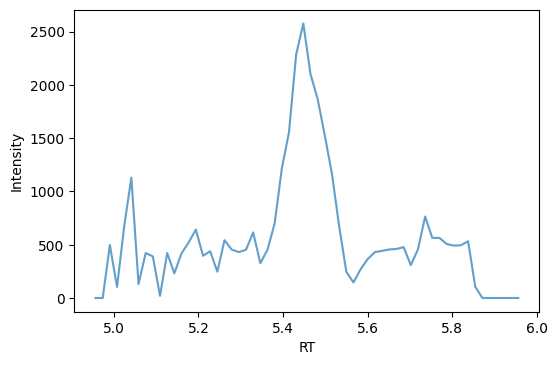

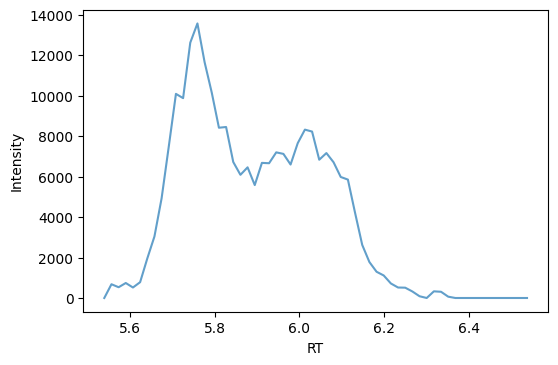

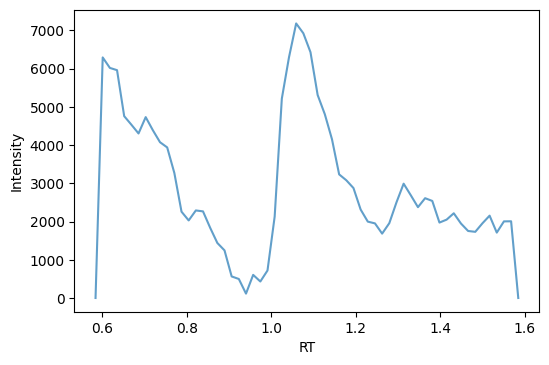

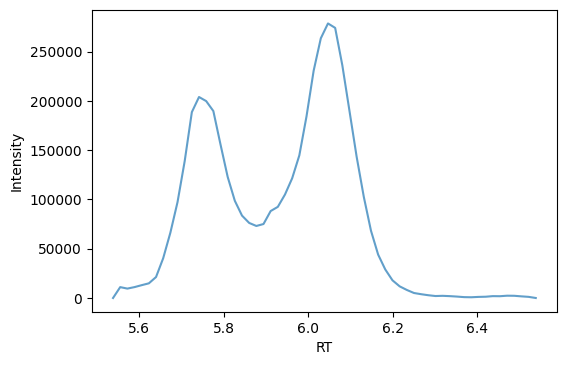

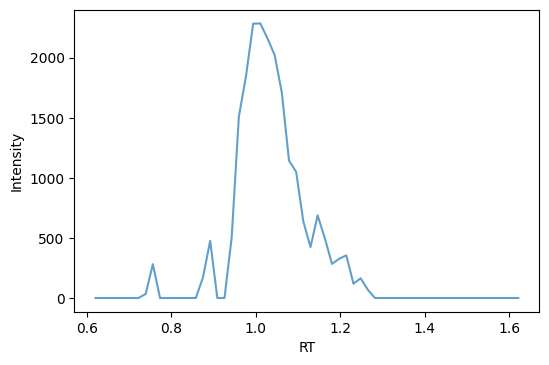

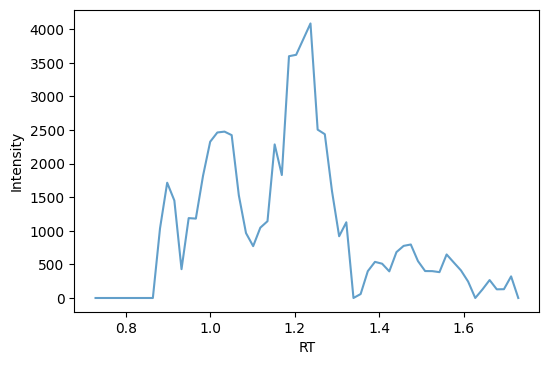

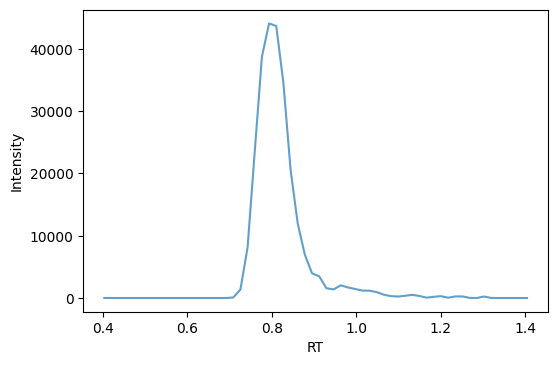

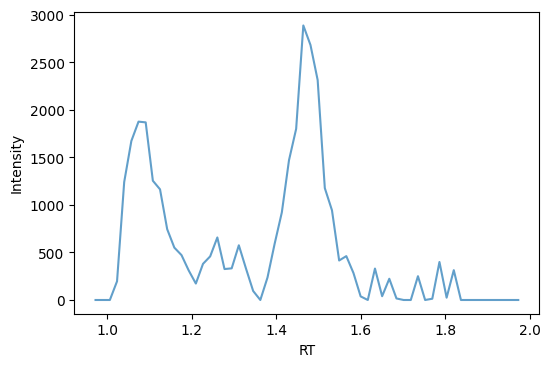

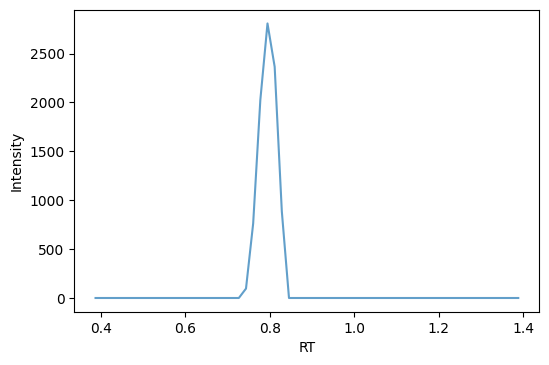

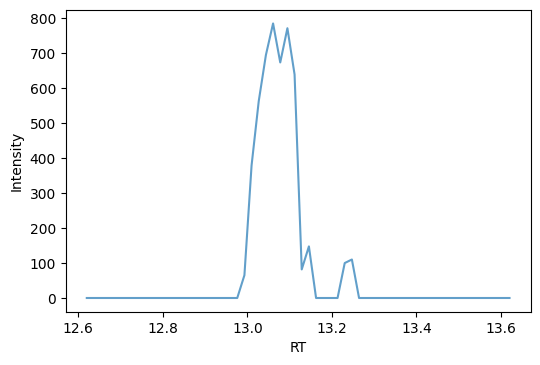

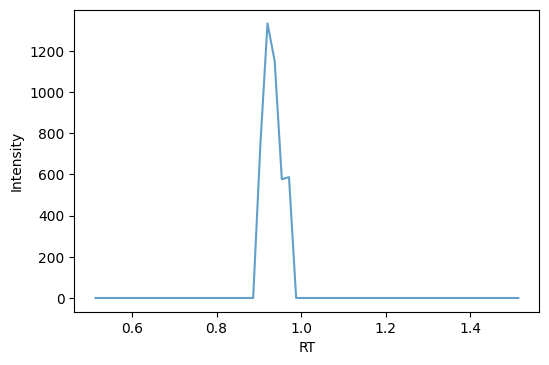

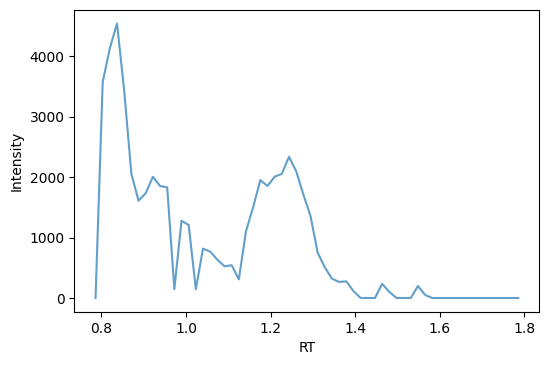

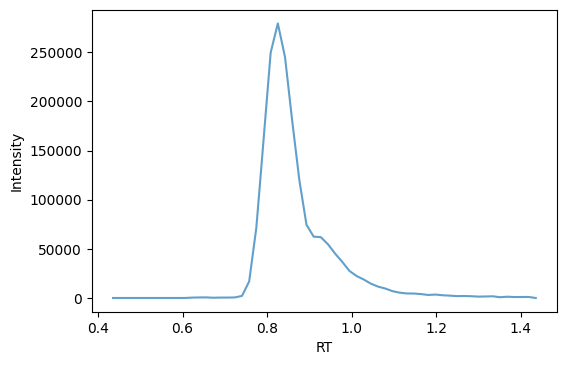

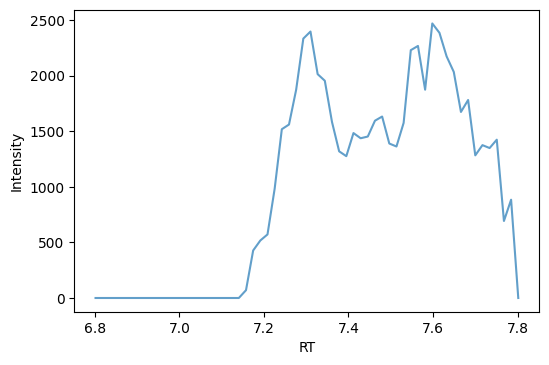

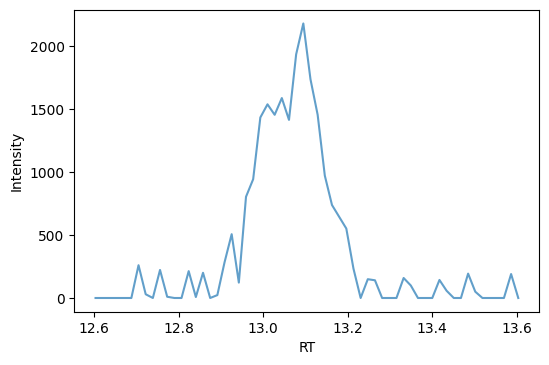

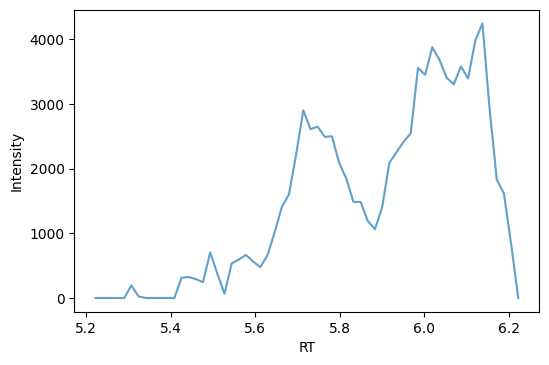

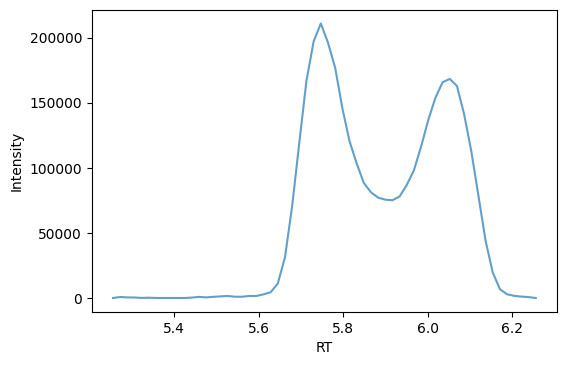

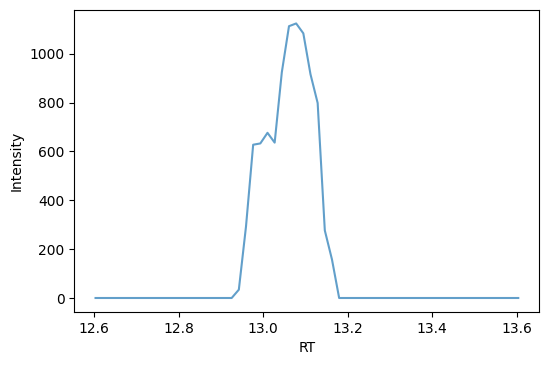

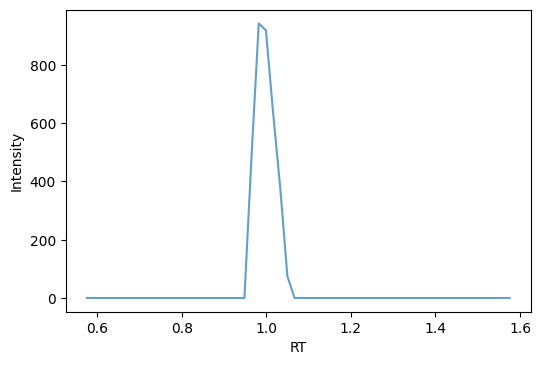

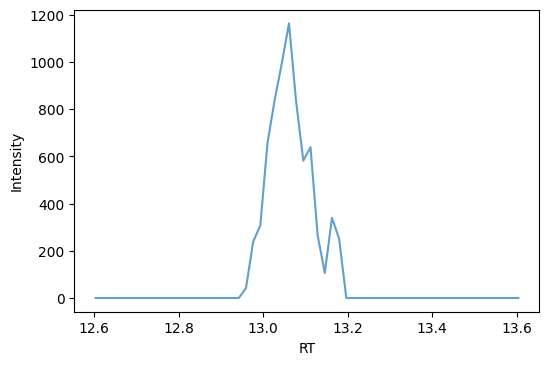

<Figure size 600x400 with 0 Axes>

In [174]:
for ind in fns:
    plot_overlayedEIC(raw_data[:1],peak_curated.at[ind,"mz"],peak_curated.at[ind,"rt"]-.5,peak_curated.at[ind,"rt"] + .5,resolution=resolution,alpha=0.7)
    plt.xlabel("RT")
    plt.ylabel("Intensity")
    plt.figure()

In [175]:
xcmsCols = [x for x in peakList.columns.values if ".mzML" in x]
xcms_peak_areas = peakList[xcmsCols]
xcms_peak_areas

B1_NIST1950_1_6540.mzML  B1_NIST1950_2_6540.mzML  \
FT0001             7.850117e+03             6.526800e+03   
FT0002             1.532210e+05             1.210493e+05   
FT0003             6.447720e+03             9.208602e+03   
FT0004             6.127502e+06             5.300639e+06   
FT0005             3.627522e+04             2.545522e+04   
...                         ...                      ...   
FT4184             1.910637e+04             1.483741e+05   
FT4185             1.358256e+04             1.228282e+04   
FT4186             3.174946e+03             5.177959e+04   
FT4187             2.855932e+04             4.999942e+04   
FT4188             1.325275e+04             1.525656e+04   

        B1_NIST1950_3_6540.mzML  
FT0001             2.891458e+05  
FT0002             1.215186e+05  
FT0003             7.405622e+03  
FT0004             5.151324e+06  
FT0005             3.088248e+04  
...                         ...  
FT4184             1.705465e+04  
FT4185             1.231674e+04  
FT4186             2.920245e+03  
FT4187             2.388595e+04  
FT4188             2.264250e+04  

[4188 rows x 3 columns]

In [176]:
pdCols = [x for x in peak_intensities.columns.values if ".mzML" in x and "D:" in x]
pd_peak_areas = peak_intensities[pdCols]
pd_peak_areas

D:/PeakDetective/data/covid_plasma/B1_NIST1950_1_6540.mzML  \
FT0001                                       0.000000e+00            
FT0002                                       1.367649e+05            
FT0003                                       4.822438e+03            
FT0004                                       6.094064e+06            
FT0005                                       1.606958e+04            
...                                                   ...            
FT4184                                       2.236934e+04            
FT4185                                       4.287676e+04            
FT4186                                       7.946560e+03            
FT4187                                       1.539005e+04            
FT4188                                       2.053003e+04            

        D:/PeakDetective/data/covid_plasma/B1_NIST1950_2_6540.mzML  \
FT0001                                       0.000000e+00            
FT0002                                       1.167683e+05            
FT0003                                       5.537448e+03            
FT0004                                       5.346899e+06            
FT0005                                       1.294121e+04            
...                                                   ...            
FT4184                                       8.865080e+04            
FT4185                                       1.516395e+05            
FT4186                                       2.958149e+04            
FT4187                                       5.006899e+04            
FT4188                                       2.195443e+04            

        D:/PeakDetective/data/covid_plasma/B1_NIST1950_3_6540.mzML  
FT0001                                       0.000000e+00           
FT0002                                       1.120328e+05           
FT0003                                       5.943119e+03           
FT0004                                       5.107849e+06           
FT0005                                       1.352604e+04           
...                                                   ...           
FT4184                                       1.808682e+04           
FT4185                                       3.620955e+04           
FT4186                                       4.661699e+03           
FT4187                                       1.260245e+04           
FT4188                                       2.622413e+04           

[4188 rows x 3 columns]

-0.1519609927573422


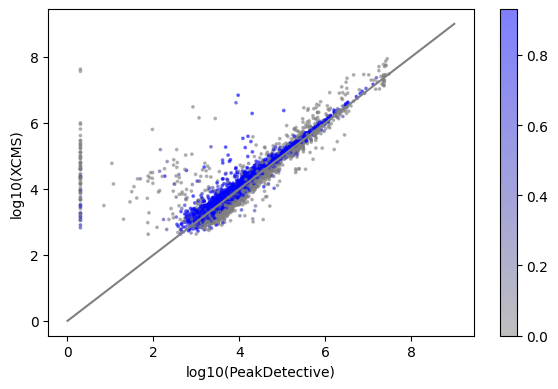

In [177]:
plt.scatter(np.log10(pd_peak_areas.values.mean(axis=1)+2),np.log10(xcms_peak_areas.values.mean(axis=1)),s=3,alpha=0.5,c=peak_scores[pdCols].values.mean(axis=1),cmap = LinearSegmentedColormap.from_list("test",colors=["grey", "blue"],N=256)
)
plt.plot([0,9],[0,9],color="grey")
plt.xlabel("log10(PeakDetective)")
plt.ylabel("log10(XCMS)")
cbar = plt.colorbar()
print(met.r2_score(pd_peak_areas.values.mean(axis=1),xcms_peak_areas.values.mean(axis=1)))
plt.tight_layout()
plt.savefig(datadir + "intensity_scatter.png",dpi=300)

Method          CV
0     PeakDetective    0.000000
1     PeakDetective    8.796037
2     PeakDetective    8.525232
3     PeakDetective    7.614849
4     PeakDetective    9.577826
...             ...         ...
8371           XCMS   99.861793
8372           XCMS    4.752486
8373           XCMS  119.081492
8374           XCMS   33.295147
8375           XCMS   23.681288

[8376 rows x 2 columns]

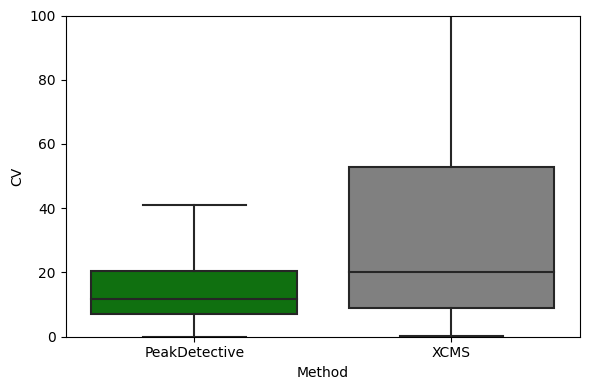

In [178]:
#TODO add cv results to each
plt_df = {}
for index,row in pd_peak_areas.iterrows():
    if np.mean(row.values) > 1:
        plt_df[len(plt_df)] = {"Method":"PeakDetective","CV":100*np.std(row.values)/np.mean(row.values)}
    else:
        plt_df[len(plt_df)] = {"Method":"PeakDetective","CV":0}
        
for index,row in xcms_peak_areas.iterrows():
    if np.mean(row.values) > 1:
        plt_df[len(plt_df)] = {"Method":"XCMS","CV":100*np.std(row.values)/np.mean(row.values)}
    else:
        plt_df[len(plt_df)] = {"Method":"XCMS","CV":0}
    
plt_df = pd.DataFrame.from_dict(plt_df,orient="index")
sb.boxplot(data=plt_df,x="Method",y="CV",fliersize=0,palette={"XCMS":"grey","PeakDetective":"green"})
plt.ylim((0,100))
plt.tight_layout()
plt.savefig(datadir+"cv_boxplot.png",dpi=300)
plt_df

In [179]:
print(plt_df[plt_df["Method"] == "PeakDetective"]["CV"].values.mean(),plt_df[plt_df["Method"] == "PeakDetective"]["CV"].values.std())
print(plt_df[plt_df["Method"] == "XCMS"]["CV"].values.mean(),plt_df[plt_df["Method"] == "XCMS"]["CV"].values.std())

18.069757283274104 21.14896846376997
35.77688997210697 36.45758678325372


In [180]:
datadir

'D:/PeakDetective/data/covid_plasma/'